<a href="https://colab.research.google.com/github/VitalyGladyshev/Python_for_DS/blob/master/HW_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ДЗ_04

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

import seaborn as sns
from sklearn.model_selection import train_test_split

from tqdm import tqdm

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report


from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from scipy.stats import ttest_rel

from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score, cross_validate

from typing import List, Optional, Dict, Tuple

!mkdir geekbrains-competitive-data-analysis

data_dir = "geekbrains-competitive-data-analysis/"

mkdir: cannot create directory ‘geekbrains-competitive-data-analysis’: File exists


In [5]:
import lightgbm as lgbm

In [6]:
!pip install catboost

In [7]:
import catboost as catb

## Загрузка данных

In [8]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [9]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"vitalygladyshev","key":"3353367a1e22b48542ed3c3946bdf3e4"}'}

In [10]:
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls -la ~/.kaggle/

total 16
drwxr-xr-x 2 root root 4096 Sep 30 16:07 .
drwx------ 1 root root 4096 Sep 30 14:49 ..
-rw------- 1 root root   71 Sep 30 16:07 kaggle.json


In [11]:
!kaggle competitions download -c geekbrains-competitive-data-analysis

  0% 0.00/586k [00:00<?, ?B/s]
100% 586k/586k [00:00<00:00, 41.4MB/s]
  0% 0.00/434k [00:00<?, ?B/s]
100% 434k/434k [00:00<00:00, 59.1MB/s]
 81% 17.0M/21.0M [00:00<00:00, 164MB/s]
100% 21.0M/21.0M [00:00<00:00, 134MB/s]
  0% 0.00/11.7M [00:00<?, ?B/s]
100% 11.7M/11.7M [00:00<00:00, 108MB/s]
  0% 0.00/632k [00:00<?, ?B/s]
100% 632k/632k [00:00<00:00, 201MB/s]
 36% 9.00M/25.2M [00:00<00:00, 35.4MB/s]
100% 25.2M/25.2M [00:00<00:00, 72.5MB/s]
 92% 55.0M/59.9M [00:00<00:00, 65.7MB/s]
100% 59.9M/59.9M [00:00<00:00, 94.2MB/s]


In [12]:
!mkdir geekbrains-competitive-data-analysis
!mv applications_history.csv.zip geekbrains-competitive-data-analysis
!mv bki.csv.zip geekbrains-competitive-data-analysis
!mv client_profile.csv.zip geekbrains-competitive-data-analysis
!mv payments.csv.zip geekbrains-competitive-data-analysis
!mv sample_submit.csv.zip geekbrains-competitive-data-analysis
!mv test.csv.zip geekbrains-competitive-data-analysis
!mv train.csv.zip geekbrains-competitive-data-analysis
!ls -la

mkdir: cannot create directory ‘geekbrains-competitive-data-analysis’: File exists
total 24
drwxr-xr-x 1 root root 4096 Sep 30 16:07 .
drwxr-xr-x 1 root root 4096 Sep 30 14:13 ..
drwxr-xr-x 6 root root 4096 Sep 30 14:58 catboost_info
drwxr-xr-x 1 root root 4096 Sep 28 16:35 .config
drwxr-xr-x 2 root root 4096 Sep 30 16:07 geekbrains-competitive-data-analysis
drwxr-xr-x 1 root root 4096 Sep 28 16:35 sample_data


In [13]:
src_list = ["train", "test", "client_profile", "applications_history", "bki", "payments"]

In [14]:
from zipfile import ZipFile

In [15]:
source = {}
for name in src_list:
    z_file = ZipFile(data_dir + name + ".csv.zip")
    z_file.extractall(data_dir)
    source[name] = pd.read_csv(data_dir + name + ".csv")

## Ключевые характеристики

In [16]:
pd.set_option('display.max_columns', 400)

In [17]:
for name in src_list:
    print(f"{name} \n {source[name].shape} \n")

train 
 (110093, 3) 

test 
 (165141, 2) 

client_profile 
 (250000, 24) 

applications_history 
 (1670214, 26) 

bki 
 (945234, 17) 

payments 
 (1023932, 8) 



In [18]:
source['train'].head(3)

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE
0,123687442,0,Cash
1,123597908,1,Cash
2,123526683,0,Cash


In [19]:
source['client_profile'].head(3)

,APPLICATION_NUMBER,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,FLAG_PHONE,FLAG_EMAIL,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,123666076,F,0,157500.0,270000.0,13500.0,Incomplete higher,Civil marriage,0.008068,8560,1549,NaN,1,0,2.0,0.329471,0.236315,0.678568,0.0,0.0,0.0,0.0,1.0,2.0
1,123423688,F,0,270000.0,536917.5,28467.0,Secondary / secondary special,Married,0.020246,23187,365243,NaN,0,0,2.0,NaN,0.442295,0.802745,0.0,0.0,0.0,0.0,1.0,1.0
2,123501780,M,1,427500.0,239850.0,23850.0,Incomplete higher,Married,0.072508,14387,326,18.0,0,0,3.0,0.409017,0.738159,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
source['applications_history'].head(3)

,PREV_APPLICATION_NUMBER,APPLICATION_NUMBER,NAME_CONTRACT_TYPE,AMOUNT_ANNUITY,AMT_APPLICATION,AMOUNT_CREDIT,AMOUNT_PAYMENT,AMOUNT_GOODS_PAYMENT,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,SELLERPLACE_AREA,CNT_PAYMENT,NAME_YIELD_GROUP,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,49298709,123595216,NaN,1730.430,17145.0,17145.0,0.0,17145.0,Approved,73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,35,12.0,middle,365243.0,42.0,300.0,42.0,37.0,0.0
1,50070639,123431468,Cash,25188.615,607500.0,679671.0,NaN,607500.0,Approved,164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,-1,36.0,low_action,365243.0,134.0,916.0,365243.0,365243.0,1.0
2,49791680,123445379,Cash,15060.735,112500.0,136444.5,NaN,112500.0,Approved,301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,-1,12.0,high,365243.0,271.0,59.0,365243.0,365243.0,1.0


In [21]:
source['applications_history'].groupby("APPLICATION_NUMBER")["APPLICATION_NUMBER"].count().sort_values()

APPLICATION_NUMBER
123423340     1
123567999     1
123744405     1
123690209     1
123567994     1
             ..
123530122    67
123565751    68
123497019    72
123589020    73
123511207    77
Name: APPLICATION_NUMBER, Length: 338857, dtype: int64

In [22]:
source['bki'].head(3)

,APPLICATION_NUMBER,BUREAU_ID,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,123538884,5223613,Active,currency 1,718.0,0,377.0,NaN,19386.81,0,675000.00,320265.495,0.0,0.0,Consumer credit,39.0,NaN
1,123436670,6207544,Closed,currency 1,696.0,0,511.0,511.0,0.00,0,93111.66,0.000,0.0,0.0,Consumer credit,505.0,NaN
2,123589020,6326395,Closed,currency 1,165.0,0,149.0,160.0,NaN,0,36000.00,0.000,0.0,0.0,Consumer credit,150.0,0.0


In [23]:
source['bki'].groupby("APPLICATION_NUMBER")["APPLICATION_NUMBER"].count().sort_values()

APPLICATION_NUMBER
123571743     1
123620010     1
123740077     1
123502086     1
123620015     1
             ..
123604794    36
123603494    39
123641404    50
123493043    51
123444199    63
Name: APPLICATION_NUMBER, Length: 273131, dtype: int64

In [24]:
source['bki'].groupby("APPLICATION_NUMBER")["APPLICATION_NUMBER"].count().sort_values().tail()

APPLICATION_NUMBER
123604794    36
123603494    39
123641404    50
123493043    51
123444199    63
Name: APPLICATION_NUMBER, dtype: int64

In [25]:
source['payments'].head(3)

,PREV_APPLICATION_NUMBER,APPLICATION_NUMBER,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,49011181,123664960,1.0,5,1002.0,1015.0,12156.615,12156.615
1,48683432,123497205,1.0,13,442.0,432.0,18392.535,10047.645
2,48652024,123749925,1.0,10,8.0,23.0,5499.945,5499.945


In [26]:
source['test'].head(3)

,APPLICATION_NUMBER,NAME_CONTRACT_TYPE
0,123724268,Cash
1,123456549,Cash
2,123428178,Credit Card


In [27]:
for name in src_list:
    print(f"{name} \n")
    source[name].info()
    print("\n")

train 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110093 entries, 0 to 110092
Data columns (total 3 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   APPLICATION_NUMBER  110093 non-null  int64 
 1   TARGET              110093 non-null  int64 
 2   NAME_CONTRACT_TYPE  110093 non-null  object
dtypes: int64(2), object(1)
memory usage: 2.5+ MB


test 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165141 entries, 0 to 165140
Data columns (total 2 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   APPLICATION_NUMBER  165141 non-null  int64 
 1   NAME_CONTRACT_TYPE  165141 non-null  object
dtypes: int64(1), object(1)
memory usage: 2.5+ MB


client_profile 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 24 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      -

In [28]:
def data_obj_discribe(data: pd.DataFrame):
# если столбец имеет тип 'object' и содержит менее 30 уникальных 
# распечатывает значения столбцов и подсчитывает количество значений

    # data: pd.DataFrame исходный датафрейм
    
    obj_fit = data.select_dtypes(include='object')
    print('*' * 100)
    for cat_colname in obj_fit.columns:
        if len(obj_fit[cat_colname].unique()) < 30:
            print(str(cat_colname) + '\n\n' + str(obj_fit[cat_colname].unique()) + '\n\n')
            print(obj_fit.groupby(cat_colname)[cat_colname].count())
            print('*' * 100 + '\n')

In [29]:
# for name in src_list:
#     obj_col = source[name].select_dtypes(include='object')
#     if not obj_col.empty:
#         print(f"\t{name}{source[name].shape}\n")
#         data_obj_discribe(source[name])

## Формируем "Большую таблицу"

### Подшиваем test к train

In [30]:
test = source['test']

In [31]:
test["TARGET"] = math.nan

In [32]:
test.head

<bound method NDFrame.head of         APPLICATION_NUMBER NAME_CONTRACT_TYPE  TARGET
0                123724268               Cash     NaN
1                123456549               Cash     NaN
2                123428178        Credit Card     NaN
3                123619984               Cash     NaN
4                123671104               Cash     NaN
...                    ...                ...     ...
165136           123487967               Cash     NaN
165137           123536402               Cash     NaN
165138           123718238               Cash     NaN
165139           123631557               Cash     NaN
165140           123433260               Cash     NaN

[165141 rows x 3 columns]>

In [33]:
data = pd.concat([source['train'], test], axis=0)
data.tail()

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE
165136,123487967,NaN,Cash
165137,123536402,NaN,Cash
165138,123718238,NaN,Cash
165139,123631557,NaN,Cash
165140,123433260,NaN,Cash


In [34]:
data.shape

(275234, 3)

### Добавляем client_profile

In [35]:
def create_client_profile_features(X: pd.DataFrame, copy: bool = True) -> pd.DataFrame:
    """
    Создание признаков на основе профиля клиентов.

    Parameters
    ----------
    X: pandas.core.frame.DataFrame
        Матрица признаков с исходным профилем клиента.

    copy: bool, optional, default = True
        Флаг использования копии датафрейма X.
        Опциональный параметр, по умолчанию, равен True.

    Returns
    -------
    X_transformed: pandas.core.frame.DataFrame
        Расширенная матрица признаков с профилем клиентов.

    """
    if copy:
        X = X.copy()

    X["DAYS_ON_LAST_JOB"] = X["DAYS_ON_LAST_JOB"].replace(365243, np.nan)
    bki_flags = [flag for flag in X.columns if "AMT_REQ_CREDIT_BUREAU" in flag]
    X["BKI_REQUESTS_COUNT"] = X[bki_flags].sum(axis=1)
    X["BKI_KURTOSIS"] = X[bki_flags].kurtosis(axis=1)

    X["EXTERNAL_SCORING_PROD"] = X["EXTERNAL_SCORING_RATING_1"] * X["EXTERNAL_SCORING_RATING_2"] * X["EXTERNAL_SCORING_RATING_3"]
    X["EXTERNAL_SCORING_WEIGHTED"] = X.EXTERNAL_SCORING_RATING_1 * 2 + X.EXTERNAL_SCORING_RATING_2 * 1 + X.EXTERNAL_SCORING_RATING_3 * 3

    for function_name in ["min", "max", "mean", "nanmedian", "var"]:
        feature_name = "EXTERNAL_SCORING_RATING_{}".format(function_name)
        X[feature_name] = eval("np.{}".format(function_name))(
            X[["EXTERNAL_SCORING_RATING_1", "EXTERNAL_SCORING_RATING_2", "EXTERNAL_SCORING_RATING_3"]], axis=1
        )

    # Отношение между основными фин. показателями
    X['RATIO_CREDIT_TO_ANNUITY'] = X['AMOUNT_CREDIT'] / X['AMOUNT_ANNUITY']
    X["RATIO_ANNUITY_TO_SALARY"] = X['AMOUNT_ANNUITY'] / X['TOTAL_SALARY']
    X['RATIO_CREDIT_TO_SALARY'] = X['AMOUNT_CREDIT'] / X['TOTAL_SALARY']
    #X["TOTAL_SALARY_NET"] = X["TOTAL_SALARY"] - X["AMOUNT_ANNUITY"]

    # Отношение фин. показателей к возрасту и временным фичам
    X["RATIO_ANNUITY_TO_AGE"] = X["AMOUNT_ANNUITY"] / X["AGE"]
    X["RATIO_CREDIT_TO_AGE"] = X["AMOUNT_CREDIT"] / X["AGE"]
    X["RATIO_SALARY_TO_AGE"] = X["TOTAL_SALARY"] / X["AGE"]
    X["RATIO_SALARY_TO_EXPERIENCE"] = X["TOTAL_SALARY"] / X["DAYS_ON_LAST_JOB"]
    X["RATIO_CREDIT_TO_EXPERIENCE"] = X["AMOUNT_CREDIT"] / X["DAYS_ON_LAST_JOB"]
    X["RATIO_ANNUITY_TO_EXPERIENCE"] = X["AMOUNT_ANNUITY"] / X["DAYS_ON_LAST_JOB"]

    # Отношение врменных признаков
    X["RATIO_AGE_TO_EXPERIENCE"] = X["AGE"] / X["DAYS_ON_LAST_JOB"]
    X["RATIO_SALARY_TO_REGION_POPULATION"] = X["TOTAL_SALARY"] * X["REGION_POPULATION"]
    X["RATIO_CAR_TO_EXPERIENCE"] = X["OWN_CAR_AGE"] / X["DAYS_ON_LAST_JOB"]
    X["RATIO_CAR_TO_AGE"] = X["OWN_CAR_AGE"] / X["AGE"]

    # Произведение фин. показателей кредита на вероятность дефолта
    # Такая штука называется математическим ожиданием дефолта или ожидаемыми потерями
    X["EXPECTED_TOTAL_LOSS_1"] = X["EXTERNAL_SCORING_RATING_1"] * X["AMOUNT_CREDIT"]
    X["EXPECTED_TOTAL_LOSS_2"] = X["EXTERNAL_SCORING_RATING_2"] * X["AMOUNT_CREDIT"]
    X["EXPECTED_TOTAL_LOSS_3"] = X["EXTERNAL_SCORING_RATING_3"] * X["AMOUNT_CREDIT"]
    X["EXPECTED_MONTHLY_LOSS_1"] = X["EXTERNAL_SCORING_RATING_1"] * X["AMOUNT_ANNUITY"]
    X["EXPECTED_MONTHLY_LOSS_2"] = X["EXTERNAL_SCORING_RATING_2"] * X["AMOUNT_ANNUITY"]
    X["EXPECTED_MONTHLY_LOSS_3"] = X["EXTERNAL_SCORING_RATING_3"] * X["AMOUNT_ANNUITY"]

    return X

In [36]:
client_profile = create_client_profile_features(source["client_profile"])
client_profile.head(n=2)

/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


,APPLICATION_NUMBER,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,FLAG_PHONE,FLAG_EMAIL,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,BKI_REQUESTS_COUNT,BKI_KURTOSIS,EXTERNAL_SCORING_PROD,EXTERNAL_SCORING_WEIGHTED,EXTERNAL_SCORING_RATING_min,EXTERNAL_SCORING_RATING_max,EXTERNAL_SCORING_RATING_mean,EXTERNAL_SCORING_RATING_nanmedian,EXTERNAL_SCORING_RATING_var,RATIO_CREDIT_TO_ANNUITY,RATIO_ANNUITY_TO_SALARY,RATIO_CREDIT_TO_SALARY,RATIO_ANNUITY_TO_AGE,RATIO_CREDIT_TO_AGE,RATIO_SALARY_TO_AGE,RATIO_SALARY_TO_EXPERIENCE,RATIO_CREDIT_TO_EXPERIENCE,RATIO_ANNUITY_TO_EXPERIENCE,RATIO_AGE_TO_EXPERIENCE,RATIO_SALARY_TO_REGION_POPULATION,RATIO_CAR_TO_EXPERIENCE,RATIO_CAR_TO_AGE,EXPECTED_TOTAL_LOSS_1,EXPECTED_TOTAL_LOSS_2,EXPECTED_TOTAL_LOSS_3,EXPECTED_MONTHLY_LOSS_1,EXPECTED_MONTHLY_LOSS_2,EXPECTED_MONTHLY_LOSS_3
0,123666076,F,0,157500.0,270000.0,13500.0,Incomplete higher,Civil marriage,0.008068,8560,1549.0,NaN,1,0,2.0,0.329471,0.236315,0.678568,0.0,0.0,0.0,0.0,1.0,2.0,3.0,1.428571,0.052832,2.930959,0.236315,0.678568,0.414784,0.329471,0.036237,20.00000,0.085714,1.714286,1.577103,31.542056,18.399533,101.678502,174.306004,8.7153,5.526146,1270.71,NaN,NaN,88957.124333,63804.966560,183213.275945,4447.856217,3190.248328,9160.663797
1,123423688,F,0,270000.0,536917.5,28467.0,Secondary / secondary special,Married,0.020246,23187,NaN,NaN,0,0,2.0,NaN,0.442295,0.802745,0.0,0.0,0.0,0.0,1.0,1.0,2.0,-1.875000,NaN,NaN,0.442295,0.802745,0.622520,0.622520,0.032481,18.86105,0.105433,1.988583,1.227714,23.155971,11.644456,NaN,NaN,NaN,NaN,5466.42,NaN,NaN,NaN,237475.743779,431008.094056,NaN,12590.802122,22851.755462


In [37]:
data = pd.merge(data, client_profile, on='APPLICATION_NUMBER', how='left')
data.head()

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,FLAG_PHONE,FLAG_EMAIL,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,BKI_REQUESTS_COUNT,BKI_KURTOSIS,EXTERNAL_SCORING_PROD,EXTERNAL_SCORING_WEIGHTED,EXTERNAL_SCORING_RATING_min,EXTERNAL_SCORING_RATING_max,EXTERNAL_SCORING_RATING_mean,EXTERNAL_SCORING_RATING_nanmedian,EXTERNAL_SCORING_RATING_var,RATIO_CREDIT_TO_ANNUITY,RATIO_ANNUITY_TO_SALARY,RATIO_CREDIT_TO_SALARY,RATIO_ANNUITY_TO_AGE,RATIO_CREDIT_TO_AGE,RATIO_SALARY_TO_AGE,RATIO_SALARY_TO_EXPERIENCE,RATIO_CREDIT_TO_EXPERIENCE,RATIO_ANNUITY_TO_EXPERIENCE,RATIO_AGE_TO_EXPERIENCE,RATIO_SALARY_TO_REGION_POPULATION,RATIO_CAR_TO_EXPERIENCE,RATIO_CAR_TO_AGE,EXPECTED_TOTAL_LOSS_1,EXPECTED_TOTAL_LOSS_2,EXPECTED_TOTAL_LOSS_3,EXPECTED_MONTHLY_LOSS_1,EXPECTED_MONTHLY_LOSS_2,EXPECTED_MONTHLY_LOSS_3
0,123687442,0.0,Cash,M,1.0,157500.0,855000.0,25128.0,Secondary / secondary special,Married,0.019101,15728.0,1719.0,11.0,0.0,0.0,3.0,0.700784,0.645914,0.716570,0.0,0.0,1.0,0.0,0.0,2.0,3.0,1.428571,0.324353,4.197193,0.645914,0.716570,0.687756,0.700784,9.169231e-04,34.025788,0.159543,5.428571,1.597660,54.361648,10.013988,91.623037,497.382199,14.617801,9.149506,3008.4075,0.006399,0.000699,599170.547652,552256.266546,612667.559305,17609.307043,16230.521013,18005.977111
1,123597908,1.0,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,123526683,0.0,Cash,F,0.0,135000.0,1006920.0,42660.0,Higher education,Married,0.026392,21557.0,3618.0,NaN,1.0,0.0,2.0,NaN,0.682149,0.267869,0.0,0.0,0.0,7.0,0.0,4.0,11.0,0.539379,NaN,NaN,0.267869,0.682149,0.475009,0.475009,4.290708e-02,23.603376,0.316000,7.458667,1.978940,46.709653,6.262467,37.313433,278.308458,11.791045,5.958264,3562.9200,NaN,NaN,NaN,686869.876357,269722.588880,NaN,29100.493510,11427.288803
3,123710391,1.0,Cash,M,0.0,180000.0,518562.0,22972.5,Secondary / secondary special,Married,0.031329,22338.0,NaN,NaN,0.0,0.0,2.0,NaN,0.171299,0.170446,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,NaN,NaN,0.170446,0.171299,0.170873,0.170873,1.818800e-07,22.573164,0.127625,2.880900,1.028405,23.214343,8.058018,NaN,NaN,NaN,NaN,5639.2200,NaN,NaN,NaN,88829.188848,88386.882459,NaN,3935.167908,3915.573562
4,123590329,1.0,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
data.tail()

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,FLAG_PHONE,FLAG_EMAIL,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,BKI_REQUESTS_COUNT,BKI_KURTOSIS,EXTERNAL_SCORING_PROD,EXTERNAL_SCORING_WEIGHTED,EXTERNAL_SCORING_RATING_min,EXTERNAL_SCORING_RATING_max,EXTERNAL_SCORING_RATING_mean,EXTERNAL_SCORING_RATING_nanmedian,EXTERNAL_SCORING_RATING_var,RATIO_CREDIT_TO_ANNUITY,RATIO_ANNUITY_TO_SALARY,RATIO_CREDIT_TO_SALARY,RATIO_ANNUITY_TO_AGE,RATIO_CREDIT_TO_AGE,RATIO_SALARY_TO_AGE,RATIO_SALARY_TO_EXPERIENCE,RATIO_CREDIT_TO_EXPERIENCE,RATIO_ANNUITY_TO_EXPERIENCE,RATIO_AGE_TO_EXPERIENCE,RATIO_SALARY_TO_REGION_POPULATION,RATIO_CAR_TO_EXPERIENCE,RATIO_CAR_TO_AGE,EXPECTED_TOTAL_LOSS_1,EXPECTED_TOTAL_LOSS_2,EXPECTED_TOTAL_LOSS_3,EXPECTED_MONTHLY_LOSS_1,EXPECTED_MONTHLY_LOSS_2,EXPECTED_MONTHLY_LOSS_3
275229,123487967,NaN,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
275230,123536402,NaN,Cash,M,0.0,135000.0,450000.0,16807.5,Secondary / secondary special,Single / not married,0.028663,18610.0,10398.0,23.0,0.0,0.0,1.0,NaN,0.665971,0.535276,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,NaN,NaN,0.535276,0.665971,0.600624,0.600624,0.004270,26.773762,0.124500,3.333333,0.903143,24.180548,7.254164,12.983266,43.277553,1.616417,1.789767,3869.5050,0.002212,0.001236,NaN,299686.841680,240874.312713,NaN,11193.303537,8996.655580
275231,123718238,NaN,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
275232,123631557,NaN,Cash,F,0.0,112500.0,350181.0,36769.5,Secondary / secondary special,Married,0.030755,20551.0,NaN,NaN,0.0,1.0,2.0,NaN,0.761376,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.761376,0.761376,0.761376,0.761376,0.000000,9.523681,0.326840,3.112720,1.789183,17.039609,5.474186,NaN,NaN,NaN,NaN,3459.9375,NaN,NaN,NaN,266619.257702,NaN,NaN,27995.398940,NaN
275233,123433260,NaN,Cash,M,0.0,247500.0,1241437.5,36427.5,Secondary / secondary special,Married,0.018029,18853.0,6543.0,15.0,0.0,0.0,2.0,NaN,0.493617,0.546023,0.0,0.0,0.0,1.0,0.0,2.0,3.0,1.428571,NaN,NaN,0.493617,0.546023,0.519820,0.519820,0.000687,34.079679,0.147182,5.015909,1.932186,65.848273,13.127884,37.826685,189.735213,5.567400,2.881400,4462.1775,0.002293,0.000796,NaN,612794.525674,677853.672632,NaN,17981.229489,19890.260009


In [39]:
data.shape

(275234, 54)

### Агрегируем категориальные характеристики из applications_history, bki, payments

In [40]:
def cat_encoder_m(data: pd.DataFrame)->pd.DataFrame:
    '''
    Функция для извлечения из датасета источника категориальных переменных и 
    кодирования count hot encoding
    
    data: pandas.core.frame.DataFrame
        датасет источник
        
    Возвращает датасет с колонкой APPLICATION_NUMBER и кололонками новых характеристик
    '''
    res_data = data[['APPLICATION_NUMBER']].copy()
    cat_data = data.select_dtypes(include=['object'])
    cat_list = []
    for cat_col in cat_data.columns:
        uniq_vals = cat_data[cat_col].unique()
        if len(uniq_vals) < 20:
            cat_list.append(cat_col)
            for uniq_val in uniq_vals:
                new_col_name = (cat_col + '_' + '_'.join(str(uniq_val).split())).upper()
                res_data[new_col_name] = 0
                res_data[new_col_name][data[cat_col] == uniq_val] = 1
#                 res_data.loc[data[cat_col] == uniq_val, new_col_name] = 1  
    return res_data

In [41]:
# for dat_name in src_list[3:]:
#     print(dat_name)
#     new_feat = cat_encoder_m(source[dat_name])
#     if len(new_feat.columns) > 1:
#         sum_feat = new_feat.groupby('APPLICATION_NUMBER')[new_feat.columns[1:]].sum()
#         print(f"\tsum cols: {sum_feat.shape}\n")
#         sum_feat.columns = [col + "_SUM" for col in sum_feat.columns]
#         data = pd.merge(data, 
#                         sum_feat, 
#                         on='APPLICATION_NUMBER', 
#                         how='left')
#         mean_feat = new_feat.groupby('APPLICATION_NUMBER')[new_feat.columns[1:]].mean()
#         print(f"\tmean cols: {mean_feat.shape}\n")
#         mean_feat.columns = [col + "_MEAN" for col in mean_feat.columns]
#         data = pd.merge(data, 
#                         mean_feat, 
#                         on='APPLICATION_NUMBER', 
#                         how='left')

In [42]:
data.head()

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,FLAG_PHONE,FLAG_EMAIL,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,BKI_REQUESTS_COUNT,BKI_KURTOSIS,EXTERNAL_SCORING_PROD,EXTERNAL_SCORING_WEIGHTED,EXTERNAL_SCORING_RATING_min,EXTERNAL_SCORING_RATING_max,EXTERNAL_SCORING_RATING_mean,EXTERNAL_SCORING_RATING_nanmedian,EXTERNAL_SCORING_RATING_var,RATIO_CREDIT_TO_ANNUITY,RATIO_ANNUITY_TO_SALARY,RATIO_CREDIT_TO_SALARY,RATIO_ANNUITY_TO_AGE,RATIO_CREDIT_TO_AGE,RATIO_SALARY_TO_AGE,RATIO_SALARY_TO_EXPERIENCE,RATIO_CREDIT_TO_EXPERIENCE,RATIO_ANNUITY_TO_EXPERIENCE,RATIO_AGE_TO_EXPERIENCE,RATIO_SALARY_TO_REGION_POPULATION,RATIO_CAR_TO_EXPERIENCE,RATIO_CAR_TO_AGE,EXPECTED_TOTAL_LOSS_1,EXPECTED_TOTAL_LOSS_2,EXPECTED_TOTAL_LOSS_3,EXPECTED_MONTHLY_LOSS_1,EXPECTED_MONTHLY_LOSS_2,EXPECTED_MONTHLY_LOSS_3
0,123687442,0.0,Cash,M,1.0,157500.0,855000.0,25128.0,Secondary / secondary special,Married,0.019101,15728.0,1719.0,11.0,0.0,0.0,3.0,0.700784,0.645914,0.716570,0.0,0.0,1.0,0.0,0.0,2.0,3.0,1.428571,0.324353,4.197193,0.645914,0.716570,0.687756,0.700784,9.169231e-04,34.025788,0.159543,5.428571,1.597660,54.361648,10.013988,91.623037,497.382199,14.617801,9.149506,3008.4075,0.006399,0.000699,599170.547652,552256.266546,612667.559305,17609.307043,16230.521013,18005.977111
1,123597908,1.0,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,123526683,0.0,Cash,F,0.0,135000.0,1006920.0,42660.0,Higher education,Married,0.026392,21557.0,3618.0,NaN,1.0,0.0,2.0,NaN,0.682149,0.267869,0.0,0.0,0.0,7.0,0.0,4.0,11.0,0.539379,NaN,NaN,0.267869,0.682149,0.475009,0.475009,4.290708e-02,23.603376,0.316000,7.458667,1.978940,46.709653,6.262467,37.313433,278.308458,11.791045,5.958264,3562.9200,NaN,NaN,NaN,686869.876357,269722.588880,NaN,29100.493510,11427.288803
3,123710391,1.0,Cash,M,0.0,180000.0,518562.0,22972.5,Secondary / secondary special,Married,0.031329,22338.0,NaN,NaN,0.0,0.0,2.0,NaN,0.171299,0.170446,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,NaN,NaN,0.170446,0.171299,0.170873,0.170873,1.818800e-07,22.573164,0.127625,2.880900,1.028405,23.214343,8.058018,NaN,NaN,NaN,NaN,5639.2200,NaN,NaN,NaN,88829.188848,88386.882459,NaN,3935.167908,3915.573562
4,123590329,1.0,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
# data.tail()

In [44]:
data.shape

(275234, 54)

In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 275234 entries, 0 to 275233
Data columns (total 54 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   APPLICATION_NUMBER                 275234 non-null  int64  
 1   TARGET                             110093 non-null  float64
 2   NAME_CONTRACT_TYPE                 275234 non-null  object 
 3   GENDER                             223715 non-null  object 
 4   CHILDRENS                          223715 non-null  float64
 5   TOTAL_SALARY                       223715 non-null  float64
 6   AMOUNT_CREDIT                      223715 non-null  float64
 7   AMOUNT_ANNUITY                     223704 non-null  float64
 8   EDUCATION_LEVEL                    223715 non-null  object 
 9   FAMILY_STATUS                      223715 non-null  object 
 10  REGION_POPULATION                  223715 non-null  float64
 11  AGE                                2237

### Заполняем пропуски

In [46]:
obj_col_names = data.select_dtypes(include=['object']).columns
obj_col_names

Index(['NAME_CONTRACT_TYPE', 'GENDER', 'EDUCATION_LEVEL', 'FAMILY_STATUS'], dtype='object')

In [47]:
data.loc[data[obj_col_names[1]].isnull(), obj_col_names[1]]

1         NaN
4         NaN
10        NaN
16        NaN
17        NaN
         ... 
275225    NaN
275226    NaN
275228    NaN
275229    NaN
275231    NaN
Name: GENDER, Length: 51519, dtype: object

In [48]:
for col in obj_col_names:
    data.loc[data[col].isnull(), col] = 'No'

In [49]:
num_col_names = data.select_dtypes(exclude=['object']).columns
num_col_names

Index(['APPLICATION_NUMBER', 'TARGET', 'CHILDRENS', 'TOTAL_SALARY',
       'AMOUNT_CREDIT', 'AMOUNT_ANNUITY', 'REGION_POPULATION', 'AGE',
       'DAYS_ON_LAST_JOB', 'OWN_CAR_AGE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'FAMILY_SIZE', 'EXTERNAL_SCORING_RATING_1', 'EXTERNAL_SCORING_RATING_2',
       'EXTERNAL_SCORING_RATING_3', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'BKI_REQUESTS_COUNT', 'BKI_KURTOSIS',
       'EXTERNAL_SCORING_PROD', 'EXTERNAL_SCORING_WEIGHTED',
       'EXTERNAL_SCORING_RATING_min', 'EXTERNAL_SCORING_RATING_max',
       'EXTERNAL_SCORING_RATING_mean', 'EXTERNAL_SCORING_RATING_nanmedian',
       'EXTERNAL_SCORING_RATING_var', 'RATIO_CREDIT_TO_ANNUITY',
       'RATIO_ANNUITY_TO_SALARY', 'RATIO_CREDIT_TO_SALARY',
       'RATIO_ANNUITY_TO_AGE', 'RATIO_CREDIT_TO_AGE', 'RATIO_SALARY_TO_AGE',
       'RATIO_SALARY_TO_EXPERIEN

In [50]:
for col in num_col_names:
    data.loc[data[col].isnull(), col] = -1

In [51]:
data.head()

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,FLAG_PHONE,FLAG_EMAIL,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,BKI_REQUESTS_COUNT,BKI_KURTOSIS,EXTERNAL_SCORING_PROD,EXTERNAL_SCORING_WEIGHTED,EXTERNAL_SCORING_RATING_min,EXTERNAL_SCORING_RATING_max,EXTERNAL_SCORING_RATING_mean,EXTERNAL_SCORING_RATING_nanmedian,EXTERNAL_SCORING_RATING_var,RATIO_CREDIT_TO_ANNUITY,RATIO_ANNUITY_TO_SALARY,RATIO_CREDIT_TO_SALARY,RATIO_ANNUITY_TO_AGE,RATIO_CREDIT_TO_AGE,RATIO_SALARY_TO_AGE,RATIO_SALARY_TO_EXPERIENCE,RATIO_CREDIT_TO_EXPERIENCE,RATIO_ANNUITY_TO_EXPERIENCE,RATIO_AGE_TO_EXPERIENCE,RATIO_SALARY_TO_REGION_POPULATION,RATIO_CAR_TO_EXPERIENCE,RATIO_CAR_TO_AGE,EXPECTED_TOTAL_LOSS_1,EXPECTED_TOTAL_LOSS_2,EXPECTED_TOTAL_LOSS_3,EXPECTED_MONTHLY_LOSS_1,EXPECTED_MONTHLY_LOSS_2,EXPECTED_MONTHLY_LOSS_3
0,123687442,0.0,Cash,M,1.0,157500.0,855000.0,25128.0,Secondary / secondary special,Married,0.019101,15728.0,1719.0,11.0,0.0,0.0,3.0,0.700784,0.645914,0.716570,0.0,0.0,1.0,0.0,0.0,2.0,3.0,1.428571,0.324353,4.197193,0.645914,0.716570,0.687756,0.700784,9.169231e-04,34.025788,0.159543,5.428571,1.597660,54.361648,10.013988,91.623037,497.382199,14.617801,9.149506,3008.4075,0.006399,0.000699,599170.547652,552256.266546,612667.559305,17609.307043,16230.521013,18005.977111
1,123597908,1.0,Cash,No,-1.0,-1.0,-1.0,-1.0,No,No,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000e+00,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
2,123526683,0.0,Cash,F,0.0,135000.0,1006920.0,42660.0,Higher education,Married,0.026392,21557.0,3618.0,-1.0,1.0,0.0,2.0,-1.000000,0.682149,0.267869,0.0,0.0,0.0,7.0,0.0,4.0,11.0,0.539379,-1.000000,-1.000000,0.267869,0.682149,0.475009,0.475009,4.290708e-02,23.603376,0.316000,7.458667,1.978940,46.709653,6.262467,37.313433,278.308458,11.791045,5.958264,3562.9200,-1.000000,-1.000000,-1.000000,686869.876357,269722.588880,-1.000000,29100.493510,11427.288803
3,123710391,1.0,Cash,M,0.0,180000.0,518562.0,22972.5,Secondary / secondary special,Married,0.031329,22338.0,-1.0,-1.0,0.0,0.0,2.0,-1.000000,0.171299,0.170446,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,-1.000000,-1.000000,0.170446,0.171299,0.170873,0.170873,1.818800e-07,22.573164,0.127625,2.880900,1.028405,23.214343,8.058018,-1.000000,-1.000000,-1.000000,-1.000000,5639.2200,-1.000000,-1.000000,-1.000000,88829.188848,88386.882459,-1.000000,3935.167908,3915.573562
4,123590329,1.0,Cash,No,-1.0,-1.0,-1.0,-1.0,No,No,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000e+00,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000


### Агрегируем числовые приазнаки из applications_history, bki, payments

In [52]:
stats = ["count", "mean", "min", "max", "std"]

In [53]:
# for dat_name in src_list[3:]:
#     print(dat_name)
#     dat = source[dat_name].select_dtypes(exclude=['object'])
#     for col in dat.columns[2:]:
#         dat.loc[dat[col].isnull(), col] = -1
#     new_feat = dat.groupby("APPLICATION_NUMBER", as_index=False)[dat.columns[2:]].agg(stats).reset_index()
#     for col in new_feat.columns[1:]:
#         new_feat.loc[new_feat[col].isnull(), col] = -1
    
# #     print(new_feat.info())
#     tmp = [new_feat.columns[0][0]]
#     tmp.extend([col[0]+"_"+col[1].upper() for col in new_feat.columns[1:]])
#     new_feat.columns = tmp
# #     print(tmp)
# #     print(new_feat.info())
#     data = pd.merge(data, 
#                     new_feat, 
#                     on='APPLICATION_NUMBER', 
#                     how='left')

In [54]:
data.shape

(275234, 54)

In [55]:
data.head(2)

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,FLAG_PHONE,FLAG_EMAIL,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,BKI_REQUESTS_COUNT,BKI_KURTOSIS,EXTERNAL_SCORING_PROD,EXTERNAL_SCORING_WEIGHTED,EXTERNAL_SCORING_RATING_min,EXTERNAL_SCORING_RATING_max,EXTERNAL_SCORING_RATING_mean,EXTERNAL_SCORING_RATING_nanmedian,EXTERNAL_SCORING_RATING_var,RATIO_CREDIT_TO_ANNUITY,RATIO_ANNUITY_TO_SALARY,RATIO_CREDIT_TO_SALARY,RATIO_ANNUITY_TO_AGE,RATIO_CREDIT_TO_AGE,RATIO_SALARY_TO_AGE,RATIO_SALARY_TO_EXPERIENCE,RATIO_CREDIT_TO_EXPERIENCE,RATIO_ANNUITY_TO_EXPERIENCE,RATIO_AGE_TO_EXPERIENCE,RATIO_SALARY_TO_REGION_POPULATION,RATIO_CAR_TO_EXPERIENCE,RATIO_CAR_TO_AGE,EXPECTED_TOTAL_LOSS_1,EXPECTED_TOTAL_LOSS_2,EXPECTED_TOTAL_LOSS_3,EXPECTED_MONTHLY_LOSS_1,EXPECTED_MONTHLY_LOSS_2,EXPECTED_MONTHLY_LOSS_3
0,123687442,0.0,Cash,M,1.0,157500.0,855000.0,25128.0,Secondary / secondary special,Married,0.019101,15728.0,1719.0,11.0,0.0,0.0,3.0,0.700784,0.645914,0.71657,0.0,0.0,1.0,0.0,0.0,2.0,3.0,1.428571,0.324353,4.197193,0.645914,0.71657,0.687756,0.700784,0.000917,34.025788,0.159543,5.428571,1.59766,54.361648,10.013988,91.623037,497.382199,14.617801,9.149506,3008.4075,0.006399,0.000699,599170.547652,552256.266546,612667.559305,17609.307043,16230.521013,18005.977111
1,123597908,1.0,Cash,No,-1.0,-1.0,-1.0,-1.0,No,No,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.00000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000


In [56]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 275234 entries, 0 to 275233
Data columns (total 54 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   APPLICATION_NUMBER                 275234 non-null  int64  
 1   TARGET                             275234 non-null  float64
 2   NAME_CONTRACT_TYPE                 275234 non-null  object 
 3   GENDER                             275234 non-null  object 
 4   CHILDRENS                          275234 non-null  float64
 5   TOTAL_SALARY                       275234 non-null  float64
 6   AMOUNT_CREDIT                      275234 non-null  float64
 7   AMOUNT_ANNUITY                     275234 non-null  float64
 8   EDUCATION_LEVEL                    275234 non-null  object 
 9   FAMILY_STATUS                      275234 non-null  object 
 10  REGION_POPULATION                  275234 non-null  float64
 11  AGE                                2752

### Ratios

In [57]:
# финансовые признаки
data["RATIO_SALARY_TO_AMOUNT_CREDIT"] = data["TOTAL_SALARY"] / data["AMOUNT_CREDIT"]
data["RATIO_AMOUNT_ANNUITY_TO_SALARY"] = data["AMOUNT_ANNUITY"] / data["TOTAL_SALARY"]

# семейные признаки
data["RATIO_SALARY_TO_PER_FAMILY_SIZE"] = data["TOTAL_SALARY"] / data["FAMILY_SIZE"]

# флаги
data["FLG_MORE_THAN_30PERCENT_FOR_CREDIT"] = np.where(
    data["RATIO_AMOUNT_ANNUITY_TO_SALARY"] > 0.42, 1, 0
)

### Features Interaction

In [58]:
data["EDUCATION_FAMILY_STATUS"] = data["EDUCATION_LEVEL"] + " | " + data["FAMILY_STATUS"]

In [59]:
data.shape

(275234, 59)

### Ещё раз заполняем пропуски

In [60]:
for col in data.select_dtypes(exclude=['object']).columns:
    data.loc[data[col].isnull(), col] = -1

In [61]:
data.head(2)

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,FLAG_PHONE,FLAG_EMAIL,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,BKI_REQUESTS_COUNT,BKI_KURTOSIS,EXTERNAL_SCORING_PROD,EXTERNAL_SCORING_WEIGHTED,EXTERNAL_SCORING_RATING_min,EXTERNAL_SCORING_RATING_max,EXTERNAL_SCORING_RATING_mean,EXTERNAL_SCORING_RATING_nanmedian,EXTERNAL_SCORING_RATING_var,RATIO_CREDIT_TO_ANNUITY,RATIO_ANNUITY_TO_SALARY,RATIO_CREDIT_TO_SALARY,RATIO_ANNUITY_TO_AGE,RATIO_CREDIT_TO_AGE,RATIO_SALARY_TO_AGE,RATIO_SALARY_TO_EXPERIENCE,RATIO_CREDIT_TO_EXPERIENCE,RATIO_ANNUITY_TO_EXPERIENCE,RATIO_AGE_TO_EXPERIENCE,RATIO_SALARY_TO_REGION_POPULATION,RATIO_CAR_TO_EXPERIENCE,RATIO_CAR_TO_AGE,EXPECTED_TOTAL_LOSS_1,EXPECTED_TOTAL_LOSS_2,EXPECTED_TOTAL_LOSS_3,EXPECTED_MONTHLY_LOSS_1,EXPECTED_MONTHLY_LOSS_2,EXPECTED_MONTHLY_LOSS_3,RATIO_SALARY_TO_AMOUNT_CREDIT,RATIO_AMOUNT_ANNUITY_TO_SALARY,RATIO_SALARY_TO_PER_FAMILY_SIZE,FLG_MORE_THAN_30PERCENT_FOR_CREDIT,EDUCATION_FAMILY_STATUS
0,123687442,0.0,Cash,M,1.0,157500.0,855000.0,25128.0,Secondary / secondary special,Married,0.019101,15728.0,1719.0,11.0,0.0,0.0,3.0,0.700784,0.645914,0.71657,0.0,0.0,1.0,0.0,0.0,2.0,3.0,1.428571,0.324353,4.197193,0.645914,0.71657,0.687756,0.700784,0.000917,34.025788,0.159543,5.428571,1.59766,54.361648,10.013988,91.623037,497.382199,14.617801,9.149506,3008.4075,0.006399,0.000699,599170.547652,552256.266546,612667.559305,17609.307043,16230.521013,18005.977111,0.184211,0.159543,52500.0,0,Secondary / secondary special | Married
1,123597908,1.0,Cash,No,-1.0,-1.0,-1.0,-1.0,No,No,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.00000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,1.000000,1.0,1,No | No


### Преобразуем категориальные признаки в числовые

In [62]:
data_cat = data.copy()

In [63]:
obj_col = data.select_dtypes(exclude=[np.number])

In [64]:
if not obj_col.empty:
    data_obj_discribe(data)

****************************************************************************************************
NAME_CONTRACT_TYPE

['Cash' 'Credit Card']


NAME_CONTRACT_TYPE
Cash           248983
Credit Card     26251
Name: NAME_CONTRACT_TYPE, dtype: int64
****************************************************************************************************

GENDER

['M' 'No' 'F' 'XNA']


GENDER
F      147444
M       76267
No      51519
XNA         4
Name: GENDER, dtype: int64
****************************************************************************************************

EDUCATION_LEVEL

['Secondary / secondary special' 'No' 'Higher education' 'Lower secondary'
 'Incomplete higher' 'Academic degree']


EDUCATION_LEVEL
Academic degree                     120
Higher education                  54516
Incomplete higher                  7456
Lower secondary                    2736
No                                51519
Secondary / secondary special    158887
Name: EDUCATION_LEVEL, dtype: int64
*

In [65]:
def data_obj_map(data: pd.DataFrame):
# если столбец имеет тип 'object' и содержит менее 30 уникальных 
# преобразует категориальные признак в числовые

    # data: pd.DataFrame исходный датафрейм
    
    # изменяет датафрейм источник
    
    obj_fit = data.select_dtypes(include='object')
    for cat_colname in obj_fit.columns:
        map_tr = {}
        un_val = obj_fit[cat_colname].unique()
        if len(un_val) < 30:
            print(str(cat_colname) + '\n')
            for i in range(len(un_val)):
                map_tr[un_val[i]] = i
            print(map_tr)
            data[cat_colname] = data[cat_colname].map(map_tr)
            print('*' * 100 + '\n')

In [66]:
if not obj_col.empty:
    data_obj_map(data)

NAME_CONTRACT_TYPE

{'Cash': 0, 'Credit Card': 1}
****************************************************************************************************

GENDER

{'M': 0, 'No': 1, 'F': 2, 'XNA': 3}
****************************************************************************************************

EDUCATION_LEVEL

{'Secondary / secondary special': 0, 'No': 1, 'Higher education': 2, 'Lower secondary': 3, 'Incomplete higher': 4, 'Academic degree': 5}
****************************************************************************************************

FAMILY_STATUS

{'Married': 0, 'No': 1, 'Single / not married': 2, 'Separated': 3, 'Civil marriage': 4, 'Widow': 5, 'Unknown': 6}
****************************************************************************************************

EDUCATION_FAMILY_STATUS

{'Secondary / secondary special | Married': 0, 'No | No': 1, 'Higher education | Married': 2, 'Secondary / secondary special | Single / not married': 3, 'Higher education | Single / not marr

In [67]:
data.head()

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,FLAG_PHONE,FLAG_EMAIL,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,BKI_REQUESTS_COUNT,BKI_KURTOSIS,EXTERNAL_SCORING_PROD,EXTERNAL_SCORING_WEIGHTED,EXTERNAL_SCORING_RATING_min,EXTERNAL_SCORING_RATING_max,EXTERNAL_SCORING_RATING_mean,EXTERNAL_SCORING_RATING_nanmedian,EXTERNAL_SCORING_RATING_var,RATIO_CREDIT_TO_ANNUITY,RATIO_ANNUITY_TO_SALARY,RATIO_CREDIT_TO_SALARY,RATIO_ANNUITY_TO_AGE,RATIO_CREDIT_TO_AGE,RATIO_SALARY_TO_AGE,RATIO_SALARY_TO_EXPERIENCE,RATIO_CREDIT_TO_EXPERIENCE,RATIO_ANNUITY_TO_EXPERIENCE,RATIO_AGE_TO_EXPERIENCE,RATIO_SALARY_TO_REGION_POPULATION,RATIO_CAR_TO_EXPERIENCE,RATIO_CAR_TO_AGE,EXPECTED_TOTAL_LOSS_1,EXPECTED_TOTAL_LOSS_2,EXPECTED_TOTAL_LOSS_3,EXPECTED_MONTHLY_LOSS_1,EXPECTED_MONTHLY_LOSS_2,EXPECTED_MONTHLY_LOSS_3,RATIO_SALARY_TO_AMOUNT_CREDIT,RATIO_AMOUNT_ANNUITY_TO_SALARY,RATIO_SALARY_TO_PER_FAMILY_SIZE,FLG_MORE_THAN_30PERCENT_FOR_CREDIT,EDUCATION_FAMILY_STATUS
0,123687442,0.0,0,0,1.0,157500.0,855000.0,25128.0,0,0,0.019101,15728.0,1719.0,11.0,0.0,0.0,3.0,0.700784,0.645914,0.716570,0.0,0.0,1.0,0.0,0.0,2.0,3.0,1.428571,0.324353,4.197193,0.645914,0.716570,0.687756,0.700784,9.169231e-04,34.025788,0.159543,5.428571,1.597660,54.361648,10.013988,91.623037,497.382199,14.617801,9.149506,3008.4075,0.006399,0.000699,599170.547652,552256.266546,612667.559305,17609.307043,16230.521013,18005.977111,0.184211,0.159543,52500.0,0,0
1,123597908,1.0,0,1,-1.0,-1.0,-1.0,-1.0,1,1,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000e+00,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,1.000000,1.0,1,1
2,123526683,0.0,0,2,0.0,135000.0,1006920.0,42660.0,2,0,0.026392,21557.0,3618.0,-1.0,1.0,0.0,2.0,-1.000000,0.682149,0.267869,0.0,0.0,0.0,7.0,0.0,4.0,11.0,0.539379,-1.000000,-1.000000,0.267869,0.682149,0.475009,0.475009,4.290708e-02,23.603376,0.316000,7.458667,1.978940,46.709653,6.262467,37.313433,278.308458,11.791045,5.958264,3562.9200,-1.000000,-1.000000,-1.000000,686869.876357,269722.588880,-1.000000,29100.493510,11427.288803,0.134072,0.316000,67500.0,0,2
3,123710391,1.0,0,0,0.0,180000.0,518562.0,22972.5,0,0,0.031329,22338.0,-1.0,-1.0,0.0,0.0,2.0,-1.000000,0.171299,0.170446,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,-1.000000,-1.000000,0.170446,0.171299,0.170873,0.170873,1.818800e-07,22.573164,0.127625,2.880900,1.028405,23.214343,8.058018,-1.000000,-1.000000,-1.000000,-1.000000,5639.2200,-1.000000,-1.000000,-1.000000,88829.188848,88386.882459,-1.000000,3935.167908,3915.573562,0.347114,0.127625,90000.0,0,0
4,123590329,1.0,0,1,-1.0,-1.0,-1.0,-1.0,1,1,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000e+00,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,1.000000,1.0,1,1


In [68]:
data_cat.head(2)

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,FLAG_PHONE,FLAG_EMAIL,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,BKI_REQUESTS_COUNT,BKI_KURTOSIS,EXTERNAL_SCORING_PROD,EXTERNAL_SCORING_WEIGHTED,EXTERNAL_SCORING_RATING_min,EXTERNAL_SCORING_RATING_max,EXTERNAL_SCORING_RATING_mean,EXTERNAL_SCORING_RATING_nanmedian,EXTERNAL_SCORING_RATING_var,RATIO_CREDIT_TO_ANNUITY,RATIO_ANNUITY_TO_SALARY,RATIO_CREDIT_TO_SALARY,RATIO_ANNUITY_TO_AGE,RATIO_CREDIT_TO_AGE,RATIO_SALARY_TO_AGE,RATIO_SALARY_TO_EXPERIENCE,RATIO_CREDIT_TO_EXPERIENCE,RATIO_ANNUITY_TO_EXPERIENCE,RATIO_AGE_TO_EXPERIENCE,RATIO_SALARY_TO_REGION_POPULATION,RATIO_CAR_TO_EXPERIENCE,RATIO_CAR_TO_AGE,EXPECTED_TOTAL_LOSS_1,EXPECTED_TOTAL_LOSS_2,EXPECTED_TOTAL_LOSS_3,EXPECTED_MONTHLY_LOSS_1,EXPECTED_MONTHLY_LOSS_2,EXPECTED_MONTHLY_LOSS_3,RATIO_SALARY_TO_AMOUNT_CREDIT,RATIO_AMOUNT_ANNUITY_TO_SALARY,RATIO_SALARY_TO_PER_FAMILY_SIZE,FLG_MORE_THAN_30PERCENT_FOR_CREDIT,EDUCATION_FAMILY_STATUS
0,123687442,0.0,Cash,M,1.0,157500.0,855000.0,25128.0,Secondary / secondary special,Married,0.019101,15728.0,1719.0,11.0,0.0,0.0,3.0,0.700784,0.645914,0.71657,0.0,0.0,1.0,0.0,0.0,2.0,3.0,1.428571,0.324353,4.197193,0.645914,0.71657,0.687756,0.700784,0.000917,34.025788,0.159543,5.428571,1.59766,54.361648,10.013988,91.623037,497.382199,14.617801,9.149506,3008.4075,0.006399,0.000699,599170.547652,552256.266546,612667.559305,17609.307043,16230.521013,18005.977111,0.184211,0.159543,52500.0,0,Secondary / secondary special | Married
1,123597908,1.0,Cash,No,-1.0,-1.0,-1.0,-1.0,No,No,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.00000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,1.000000,1.0,1,No | No


### Разделяем train и test

In [69]:
train_prep = data.loc[data['TARGET'] != -1]
train_prep.shape

(110093, 59)

In [70]:
train_cat_prep = data_cat.loc[data['TARGET'] != -1]
train_cat_prep.shape

(110093, 59)

In [71]:
train_prep.head(3)

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,FLAG_PHONE,FLAG_EMAIL,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,BKI_REQUESTS_COUNT,BKI_KURTOSIS,EXTERNAL_SCORING_PROD,EXTERNAL_SCORING_WEIGHTED,EXTERNAL_SCORING_RATING_min,EXTERNAL_SCORING_RATING_max,EXTERNAL_SCORING_RATING_mean,EXTERNAL_SCORING_RATING_nanmedian,EXTERNAL_SCORING_RATING_var,RATIO_CREDIT_TO_ANNUITY,RATIO_ANNUITY_TO_SALARY,RATIO_CREDIT_TO_SALARY,RATIO_ANNUITY_TO_AGE,RATIO_CREDIT_TO_AGE,RATIO_SALARY_TO_AGE,RATIO_SALARY_TO_EXPERIENCE,RATIO_CREDIT_TO_EXPERIENCE,RATIO_ANNUITY_TO_EXPERIENCE,RATIO_AGE_TO_EXPERIENCE,RATIO_SALARY_TO_REGION_POPULATION,RATIO_CAR_TO_EXPERIENCE,RATIO_CAR_TO_AGE,EXPECTED_TOTAL_LOSS_1,EXPECTED_TOTAL_LOSS_2,EXPECTED_TOTAL_LOSS_3,EXPECTED_MONTHLY_LOSS_1,EXPECTED_MONTHLY_LOSS_2,EXPECTED_MONTHLY_LOSS_3,RATIO_SALARY_TO_AMOUNT_CREDIT,RATIO_AMOUNT_ANNUITY_TO_SALARY,RATIO_SALARY_TO_PER_FAMILY_SIZE,FLG_MORE_THAN_30PERCENT_FOR_CREDIT,EDUCATION_FAMILY_STATUS
0,123687442,0.0,0,0,1.0,157500.0,855000.0,25128.0,0,0,0.019101,15728.0,1719.0,11.0,0.0,0.0,3.0,0.700784,0.645914,0.716570,0.0,0.0,1.0,0.0,0.0,2.0,3.0,1.428571,0.324353,4.197193,0.645914,0.716570,0.687756,0.700784,0.000917,34.025788,0.159543,5.428571,1.59766,54.361648,10.013988,91.623037,497.382199,14.617801,9.149506,3008.4075,0.006399,0.000699,599170.547652,552256.266546,612667.559305,17609.307043,16230.521013,18005.977111,0.184211,0.159543,52500.0,0,0
1,123597908,1.0,0,1,-1.0,-1.0,-1.0,-1.0,1,1,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,1.000000,1.0,1,1
2,123526683,0.0,0,2,0.0,135000.0,1006920.0,42660.0,2,0,0.026392,21557.0,3618.0,-1.0,1.0,0.0,2.0,-1.000000,0.682149,0.267869,0.0,0.0,0.0,7.0,0.0,4.0,11.0,0.539379,-1.000000,-1.000000,0.267869,0.682149,0.475009,0.475009,0.042907,23.603376,0.316000,7.458667,1.97894,46.709653,6.262467,37.313433,278.308458,11.791045,5.958264,3562.9200,-1.000000,-1.000000,-1.000000,686869.876357,269722.588880,-1.000000,29100.493510,11427.288803,0.134072,0.316000,67500.0,0,2


In [72]:
train_cat_prep.head(3)

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,FLAG_PHONE,FLAG_EMAIL,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,BKI_REQUESTS_COUNT,BKI_KURTOSIS,EXTERNAL_SCORING_PROD,EXTERNAL_SCORING_WEIGHTED,EXTERNAL_SCORING_RATING_min,EXTERNAL_SCORING_RATING_max,EXTERNAL_SCORING_RATING_mean,EXTERNAL_SCORING_RATING_nanmedian,EXTERNAL_SCORING_RATING_var,RATIO_CREDIT_TO_ANNUITY,RATIO_ANNUITY_TO_SALARY,RATIO_CREDIT_TO_SALARY,RATIO_ANNUITY_TO_AGE,RATIO_CREDIT_TO_AGE,RATIO_SALARY_TO_AGE,RATIO_SALARY_TO_EXPERIENCE,RATIO_CREDIT_TO_EXPERIENCE,RATIO_ANNUITY_TO_EXPERIENCE,RATIO_AGE_TO_EXPERIENCE,RATIO_SALARY_TO_REGION_POPULATION,RATIO_CAR_TO_EXPERIENCE,RATIO_CAR_TO_AGE,EXPECTED_TOTAL_LOSS_1,EXPECTED_TOTAL_LOSS_2,EXPECTED_TOTAL_LOSS_3,EXPECTED_MONTHLY_LOSS_1,EXPECTED_MONTHLY_LOSS_2,EXPECTED_MONTHLY_LOSS_3,RATIO_SALARY_TO_AMOUNT_CREDIT,RATIO_AMOUNT_ANNUITY_TO_SALARY,RATIO_SALARY_TO_PER_FAMILY_SIZE,FLG_MORE_THAN_30PERCENT_FOR_CREDIT,EDUCATION_FAMILY_STATUS
0,123687442,0.0,Cash,M,1.0,157500.0,855000.0,25128.0,Secondary / secondary special,Married,0.019101,15728.0,1719.0,11.0,0.0,0.0,3.0,0.700784,0.645914,0.716570,0.0,0.0,1.0,0.0,0.0,2.0,3.0,1.428571,0.324353,4.197193,0.645914,0.716570,0.687756,0.700784,0.000917,34.025788,0.159543,5.428571,1.59766,54.361648,10.013988,91.623037,497.382199,14.617801,9.149506,3008.4075,0.006399,0.000699,599170.547652,552256.266546,612667.559305,17609.307043,16230.521013,18005.977111,0.184211,0.159543,52500.0,0,Secondary / secondary special | Married
1,123597908,1.0,Cash,No,-1.0,-1.0,-1.0,-1.0,No,No,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,1.000000,1.0,1,No | No
2,123526683,0.0,Cash,F,0.0,135000.0,1006920.0,42660.0,Higher education,Married,0.026392,21557.0,3618.0,-1.0,1.0,0.0,2.0,-1.000000,0.682149,0.267869,0.0,0.0,0.0,7.0,0.0,4.0,11.0,0.539379,-1.000000,-1.000000,0.267869,0.682149,0.475009,0.475009,0.042907,23.603376,0.316000,7.458667,1.97894,46.709653,6.262467,37.313433,278.308458,11.791045,5.958264,3562.9200,-1.000000,-1.000000,-1.000000,686869.876357,269722.588880,-1.000000,29100.493510,11427.288803,0.134072,0.316000,67500.0,0,Higher education | Married


In [73]:
source['train'].head()

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE
0,123687442,0,Cash
1,123597908,1,Cash
2,123526683,0,Cash
3,123710391,1,Cash
4,123590329,1,Cash


In [74]:
train_prep.tail()

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,FLAG_PHONE,FLAG_EMAIL,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,BKI_REQUESTS_COUNT,BKI_KURTOSIS,EXTERNAL_SCORING_PROD,EXTERNAL_SCORING_WEIGHTED,EXTERNAL_SCORING_RATING_min,EXTERNAL_SCORING_RATING_max,EXTERNAL_SCORING_RATING_mean,EXTERNAL_SCORING_RATING_nanmedian,EXTERNAL_SCORING_RATING_var,RATIO_CREDIT_TO_ANNUITY,RATIO_ANNUITY_TO_SALARY,RATIO_CREDIT_TO_SALARY,RATIO_ANNUITY_TO_AGE,RATIO_CREDIT_TO_AGE,RATIO_SALARY_TO_AGE,RATIO_SALARY_TO_EXPERIENCE,RATIO_CREDIT_TO_EXPERIENCE,RATIO_ANNUITY_TO_EXPERIENCE,RATIO_AGE_TO_EXPERIENCE,RATIO_SALARY_TO_REGION_POPULATION,RATIO_CAR_TO_EXPERIENCE,RATIO_CAR_TO_AGE,EXPECTED_TOTAL_LOSS_1,EXPECTED_TOTAL_LOSS_2,EXPECTED_TOTAL_LOSS_3,EXPECTED_MONTHLY_LOSS_1,EXPECTED_MONTHLY_LOSS_2,EXPECTED_MONTHLY_LOSS_3,RATIO_SALARY_TO_AMOUNT_CREDIT,RATIO_AMOUNT_ANNUITY_TO_SALARY,RATIO_SALARY_TO_PER_FAMILY_SIZE,FLG_MORE_THAN_30PERCENT_FOR_CREDIT,EDUCATION_FAMILY_STATUS
110088,123458312,0.0,0,1,-1.0,-1.0,-1.0,-1.0,1,1,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,1.000000,1.0,1,1
110089,123672463,0.0,0,2,0.0,175500.0,269550.0,12618.0,0,0,0.010032,10519.0,1354.0,-1.0,0.0,0.0,2.0,0.528096,0.471774,0.581484,0.0,0.0,0.0,0.0,0.0,2.0,2.0,6.000,0.144872,3.272417,0.471774,0.581484,0.527118,0.528096,0.002007,21.362340,0.071897,1.535897,1.199544,25.625059,16.684095,129.615953,199.076809,9.319055,7.768833,1760.6160,-1.000000,-1.000000,142348.303154,127166.558499,156738.932900,6663.516562,5952.838565,7337.161400,0.651085,0.071897,87750.0,0,0
110090,123723001,0.0,0,1,-1.0,-1.0,-1.0,-1.0,1,1,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,1.000000,1.0,1,1
110091,123554358,0.0,0,2,2.0,270000.0,1024740.0,49428.0,4,0,0.019101,15008.0,361.0,22.0,0.0,0.0,4.0,0.653826,0.651227,0.558507,0.0,0.0,0.0,1.0,0.0,1.0,2.0,-1.875,0.237806,3.634399,0.558507,0.653826,0.621186,0.651227,0.001966,20.731974,0.183067,3.795333,3.293443,68.279584,17.990405,747.922438,2838.614958,136.919668,41.573407,5157.2700,0.060942,0.001466,670001.539719,667338.205604,572324.081646,32317.305956,32188.840903,27605.865593,0.263481,0.183067,67500.0,0,10
110092,123676265,0.0,1,2,1.0,112500.0,337500.0,16875.0,0,0,0.031329,15781.0,258.0,-1.0,0.0,0.0,3.0,-1.000000,0.552043,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.000,-1.000000,-1.000000,0.552043,0.552043,0.552043,0.552043,0.000000,20.000000,0.150000,3.000000,1.069324,21.386477,7.128826,436.046512,1308.139535,65.406977,61.166667,3524.5125,-1.000000,-1.000000,-1.000000,186314.656055,-1.000000,-1.000000,9315.732803,-1.000000,0.333333,0.150000,37500.0,0,0


In [75]:
source['train'].tail()

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE
110088,123458312,0,Cash
110089,123672463,0,Cash
110090,123723001,0,Cash
110091,123554358,0,Cash
110092,123676265,0,Credit Card


In [76]:
test_prep = data.loc[data['TARGET'] == -1].copy().reset_index(drop=True)
test_prep.drop('TARGET', axis=1, inplace=True)
test_prep.shape

(165141, 58)

In [77]:
test_cat_prep = data_cat.loc[data_cat['TARGET'] == -1].copy().reset_index(drop=True)
test_cat_prep.drop('TARGET', axis=1, inplace=True)
test_cat_prep.shape

(165141, 58)

In [78]:
test_prep.head(3)

,APPLICATION_NUMBER,NAME_CONTRACT_TYPE,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,FLAG_PHONE,FLAG_EMAIL,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,BKI_REQUESTS_COUNT,BKI_KURTOSIS,EXTERNAL_SCORING_PROD,EXTERNAL_SCORING_WEIGHTED,EXTERNAL_SCORING_RATING_min,EXTERNAL_SCORING_RATING_max,EXTERNAL_SCORING_RATING_mean,EXTERNAL_SCORING_RATING_nanmedian,EXTERNAL_SCORING_RATING_var,RATIO_CREDIT_TO_ANNUITY,RATIO_ANNUITY_TO_SALARY,RATIO_CREDIT_TO_SALARY,RATIO_ANNUITY_TO_AGE,RATIO_CREDIT_TO_AGE,RATIO_SALARY_TO_AGE,RATIO_SALARY_TO_EXPERIENCE,RATIO_CREDIT_TO_EXPERIENCE,RATIO_ANNUITY_TO_EXPERIENCE,RATIO_AGE_TO_EXPERIENCE,RATIO_SALARY_TO_REGION_POPULATION,RATIO_CAR_TO_EXPERIENCE,RATIO_CAR_TO_AGE,EXPECTED_TOTAL_LOSS_1,EXPECTED_TOTAL_LOSS_2,EXPECTED_TOTAL_LOSS_3,EXPECTED_MONTHLY_LOSS_1,EXPECTED_MONTHLY_LOSS_2,EXPECTED_MONTHLY_LOSS_3,RATIO_SALARY_TO_AMOUNT_CREDIT,RATIO_AMOUNT_ANNUITY_TO_SALARY,RATIO_SALARY_TO_PER_FAMILY_SIZE,FLG_MORE_THAN_30PERCENT_FOR_CREDIT,EDUCATION_FAMILY_STATUS
0,123724268,0,0,0.0,117000.0,1125000.0,32895.0,0,0,0.028663,16007.0,2646.0,20.0,0.0,0.0,2.0,-1.0,0.628266,-1.000000,0.0,0.0,0.0,0.0,1.0,4.0,5.0,4.639906,-1.0,-1.0,0.628266,0.628266,0.628266,0.628266,0.000000,34.199726,0.281154,9.615385,2.055038,70.281752,7.309302,44.217687,425.170068,12.431973,6.049509,3353.5710,0.007559,0.001249,-1.0,706799.427892,-1.000000,-1.0,20666.815272,-1.000000,0.104000,0.281154,58500.0,0,0
1,123456549,0,2,2.0,81000.0,312768.0,17095.5,0,0,0.019689,10315.0,459.0,-1.0,0.0,0.0,4.0,-1.0,0.578161,0.188490,0.0,0.0,1.0,0.0,0.0,2.0,3.0,1.428571,-1.0,-1.0,0.188490,0.578161,0.383325,0.383325,0.037961,18.295341,0.211056,3.861333,1.657344,30.321667,7.852642,176.470588,681.411765,37.245098,22.472767,1594.8090,-1.000000,-1.000000,-1.0,180830.265914,58953.494506,-1.0,9883.951718,3222.322825,0.258978,0.211056,20250.0,0,0
2,123428178,1,2,2.0,157500.0,450000.0,22500.0,0,0,0.019101,13016.0,977.0,-1.0,1.0,0.0,4.0,-1.0,0.152544,0.382502,0.0,0.0,0.0,0.0,1.0,6.0,7.0,5.393765,-1.0,-1.0,0.152544,0.382502,0.267523,0.267523,0.013220,20.000000,0.142857,2.857143,1.728642,34.572833,12.100492,161.207779,460.593654,23.029683,13.322416,3008.4075,-1.000000,-1.000000,-1.0,68644.984320,172125.811865,-1.0,3432.249216,8606.290593,0.350000,0.142857,39375.0,0,0


In [79]:
test_cat_prep.head(3)

,APPLICATION_NUMBER,NAME_CONTRACT_TYPE,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,FLAG_PHONE,FLAG_EMAIL,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,BKI_REQUESTS_COUNT,BKI_KURTOSIS,EXTERNAL_SCORING_PROD,EXTERNAL_SCORING_WEIGHTED,EXTERNAL_SCORING_RATING_min,EXTERNAL_SCORING_RATING_max,EXTERNAL_SCORING_RATING_mean,EXTERNAL_SCORING_RATING_nanmedian,EXTERNAL_SCORING_RATING_var,RATIO_CREDIT_TO_ANNUITY,RATIO_ANNUITY_TO_SALARY,RATIO_CREDIT_TO_SALARY,RATIO_ANNUITY_TO_AGE,RATIO_CREDIT_TO_AGE,RATIO_SALARY_TO_AGE,RATIO_SALARY_TO_EXPERIENCE,RATIO_CREDIT_TO_EXPERIENCE,RATIO_ANNUITY_TO_EXPERIENCE,RATIO_AGE_TO_EXPERIENCE,RATIO_SALARY_TO_REGION_POPULATION,RATIO_CAR_TO_EXPERIENCE,RATIO_CAR_TO_AGE,EXPECTED_TOTAL_LOSS_1,EXPECTED_TOTAL_LOSS_2,EXPECTED_TOTAL_LOSS_3,EXPECTED_MONTHLY_LOSS_1,EXPECTED_MONTHLY_LOSS_2,EXPECTED_MONTHLY_LOSS_3,RATIO_SALARY_TO_AMOUNT_CREDIT,RATIO_AMOUNT_ANNUITY_TO_SALARY,RATIO_SALARY_TO_PER_FAMILY_SIZE,FLG_MORE_THAN_30PERCENT_FOR_CREDIT,EDUCATION_FAMILY_STATUS
0,123724268,Cash,M,0.0,117000.0,1125000.0,32895.0,Secondary / secondary special,Married,0.028663,16007.0,2646.0,20.0,0.0,0.0,2.0,-1.0,0.628266,-1.000000,0.0,0.0,0.0,0.0,1.0,4.0,5.0,4.639906,-1.0,-1.0,0.628266,0.628266,0.628266,0.628266,0.000000,34.199726,0.281154,9.615385,2.055038,70.281752,7.309302,44.217687,425.170068,12.431973,6.049509,3353.5710,0.007559,0.001249,-1.0,706799.427892,-1.000000,-1.0,20666.815272,-1.000000,0.104000,0.281154,58500.0,0,Secondary / secondary special | Married
1,123456549,Cash,F,2.0,81000.0,312768.0,17095.5,Secondary / secondary special,Married,0.019689,10315.0,459.0,-1.0,0.0,0.0,4.0,-1.0,0.578161,0.188490,0.0,0.0,1.0,0.0,0.0,2.0,3.0,1.428571,-1.0,-1.0,0.188490,0.578161,0.383325,0.383325,0.037961,18.295341,0.211056,3.861333,1.657344,30.321667,7.852642,176.470588,681.411765,37.245098,22.472767,1594.8090,-1.000000,-1.000000,-1.0,180830.265914,58953.494506,-1.0,9883.951718,3222.322825,0.258978,0.211056,20250.0,0,Secondary / secondary special | Married
2,123428178,Credit Card,F,2.0,157500.0,450000.0,22500.0,Secondary / secondary special,Married,0.019101,13016.0,977.0,-1.0,1.0,0.0,4.0,-1.0,0.152544,0.382502,0.0,0.0,0.0,0.0,1.0,6.0,7.0,5.393765,-1.0,-1.0,0.152544,0.382502,0.267523,0.267523,0.013220,20.000000,0.142857,2.857143,1.728642,34.572833,12.100492,161.207779,460.593654,23.029683,13.322416,3008.4075,-1.000000,-1.000000,-1.0,68644.984320,172125.811865,-1.0,3432.249216,8606.290593,0.350000,0.142857,39375.0,0,Secondary / secondary special | Married


In [80]:
source['test'].head()

,APPLICATION_NUMBER,NAME_CONTRACT_TYPE,TARGET
0,123724268,Cash,NaN
1,123456549,Cash,NaN
2,123428178,Credit Card,NaN
3,123619984,Cash,NaN
4,123671104,Cash,NaN


In [81]:
test_prep.tail()

,APPLICATION_NUMBER,NAME_CONTRACT_TYPE,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,FLAG_PHONE,FLAG_EMAIL,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,BKI_REQUESTS_COUNT,BKI_KURTOSIS,EXTERNAL_SCORING_PROD,EXTERNAL_SCORING_WEIGHTED,EXTERNAL_SCORING_RATING_min,EXTERNAL_SCORING_RATING_max,EXTERNAL_SCORING_RATING_mean,EXTERNAL_SCORING_RATING_nanmedian,EXTERNAL_SCORING_RATING_var,RATIO_CREDIT_TO_ANNUITY,RATIO_ANNUITY_TO_SALARY,RATIO_CREDIT_TO_SALARY,RATIO_ANNUITY_TO_AGE,RATIO_CREDIT_TO_AGE,RATIO_SALARY_TO_AGE,RATIO_SALARY_TO_EXPERIENCE,RATIO_CREDIT_TO_EXPERIENCE,RATIO_ANNUITY_TO_EXPERIENCE,RATIO_AGE_TO_EXPERIENCE,RATIO_SALARY_TO_REGION_POPULATION,RATIO_CAR_TO_EXPERIENCE,RATIO_CAR_TO_AGE,EXPECTED_TOTAL_LOSS_1,EXPECTED_TOTAL_LOSS_2,EXPECTED_TOTAL_LOSS_3,EXPECTED_MONTHLY_LOSS_1,EXPECTED_MONTHLY_LOSS_2,EXPECTED_MONTHLY_LOSS_3,RATIO_SALARY_TO_AMOUNT_CREDIT,RATIO_AMOUNT_ANNUITY_TO_SALARY,RATIO_SALARY_TO_PER_FAMILY_SIZE,FLG_MORE_THAN_30PERCENT_FOR_CREDIT,EDUCATION_FAMILY_STATUS
165136,123487967,0,1,-1.0,-1.0,-1.0,-1.0,1,1,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,1.000000,1.000000,1.0,1,1
165137,123536402,0,0,0.0,135000.0,450000.0,16807.5,0,2,0.028663,18610.0,10398.0,23.0,0.0,0.0,1.0,-1.0,0.665971,0.535276,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,-1.0,-1.0,0.535276,0.665971,0.600624,0.600624,0.004270,26.773762,0.124500,3.333333,0.903143,24.180548,7.254164,12.983266,43.277553,1.616417,1.789767,3869.5050,0.002212,0.001236,-1.0,299686.841680,240874.312713,-1.0,11193.303537,8996.655580,0.300000,0.124500,135000.0,0,3
165138,123718238,0,1,-1.0,-1.0,-1.0,-1.0,1,1,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,1.000000,1.000000,1.0,1,1
165139,123631557,0,2,0.0,112500.0,350181.0,36769.5,0,0,0.030755,20551.0,-1.0,-1.0,0.0,1.0,2.0,-1.0,0.761376,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.000000,-1.0,-1.0,0.761376,0.761376,0.761376,0.761376,0.000000,9.523681,0.326840,3.112720,1.789183,17.039609,5.474186,-1.000000,-1.000000,-1.000000,-1.000000,3459.9375,-1.000000,-1.000000,-1.0,266619.257702,-1.000000,-1.0,27995.398940,-1.000000,0.321262,0.326840,56250.0,0,0
165140,123433260,0,0,0.0,247500.0,1241437.5,36427.5,0,0,0.018029,18853.0,6543.0,15.0,0.0,0.0,2.0,-1.0,0.493617,0.546023,0.0,0.0,0.0,1.0,0.0,2.0,3.0,1.428571,-1.0,-1.0,0.493617,0.546023,0.519820,0.519820,0.000687,34.079679,0.147182,5.015909,1.932186,65.848273,13.127884,37.826685,189.735213,5.567400,2.881400,4462.1775,0.002293,0.000796,-1.0,612794.525674,677853.672632,-1.0,17981.229489,19890.260009,0.199366,0.147182,123750.0,0,0


In [82]:
source['test'].tail()

,APPLICATION_NUMBER,NAME_CONTRACT_TYPE,TARGET
165136,123487967,Cash,NaN
165137,123536402,Cash,NaN
165138,123718238,Cash,NaN
165139,123631557,Cash,NaN
165140,123433260,Cash,NaN


### Сохраняем train и test

In [83]:
train_prep.to_csv(data_dir + "train_prep.csv", sep=";", index=False)

In [84]:
test_prep.to_csv(data_dir + "test_prep.csv", sep=";", index=False)

In [85]:
train_cat_prep.to_csv(data_dir + "train_cat_prep.csv", sep=";", index=False)

In [86]:
test_cat_prep.to_csv(data_dir + "test_cat_prep.csv", sep=";", index=False)

In [87]:
# from google.colab import files
# files.upload()

In [88]:
# train_prep = pd.read_csv(data_dir + "train_prep.csv")

In [89]:
# test_prep = pd.read_csv(data_dir + "test_prep.csv")

## Валидация на LightGBM

In [90]:
def make_cross_validation_adapt_l(X: pd.DataFrame,
                                  y: pd.Series,
                                  params: Dict,
                                  metric: callable,
                                  cv_strategy):
    """
    Кросс-валидация.

    Parameters
    ----------
    X: pd.DataFrame
        Матрица признаков.

    y: pd.Series
        Вектор целевой переменной.

    params: Dict
        Параметры модели.

    metric: callable
        Метрика для оценки качества решения.
        Ожидается, что на вход будет передана функция,
        которая принимает 2 аргумента: y_true, y_pred.

    cv_strategy: cross-validation generator
        Объект для описания стратегии кросс-валидации.
        Ожидается, что на вход будет передан объект типа
        KFold или StratifiedKFold.

    Returns
    -------
    oof_score: float
        Значение метрики качества на OOF-прогнозах.

    fold_train_scores: List[float]
        Значение метрики качества на каждом обучающем датасете кросс-валидации.

    fold_valid_scores: List[float]
        Значение метрики качества на каждом валидационном датасете кросс-валидации.

    oof_predictions: np.array
        Прогнозы на OOF.

    """
    estimators, fold_train_scores, fold_valid_scores = [], [], []
    oof_predictions = np.zeros(X.shape[0]) 
    
    for fold_number, (train_idx, valid_idx) in enumerate(cv_strategy.split(X, y)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y.loc[train_idx], y.loc[valid_idx]

        model = lgbm.LGBMRegressor(num_leaves=params['num_leaves'],
                                #    max_depth=params['max_depth'], 
                                   n_estimators=params["n_estimators"],
                                   learning_rate=params['learning_rate'],
                                   subsample=0.5, 
                                   seed=42)

        model.fit(x_train, 
                  y_train, 
                  early_stopping_rounds=50, 
                  eval_set = [(x_valid, y_valid)], 
                  eval_metric = 'auc',
                  verbose=False)

        y_train_pred = model.predict(x_train)
        y_valid_pred = model.predict(x_valid)

        fold_train_scores.append(metric(y_train, y_train_pred))
        fold_valid_scores.append(metric(y_valid, y_valid_pred))
        oof_predictions[valid_idx] = y_valid_pred

        msg = (
            f"Fold: {fold_number+1}, train-observations = {len(train_idx)}, "
            f"valid-observations = {len(valid_idx)}\n"
            f"train-score = {round(fold_train_scores[fold_number], 4)}, "
            f"valid-score = {round(fold_valid_scores[fold_number], 4)}" 
        )
        print(msg)
        print("="*69)
        estimators.append(model)

    oof_score = metric(y, oof_predictions)
    print(f"CV-results train: {round(np.mean(fold_train_scores), 4)} +/- {round(np.std(fold_train_scores), 3)}")
    print(f"CV-results valid: {round(np.mean(fold_valid_scores), 4)} +/- {round(np.std(fold_valid_scores), 3)}")
    print(f"OOF-score = {round(oof_score, 4)}")

    return estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions

In [91]:
parameters_l = {
    'num_leaves': 31,
    'n_estimators': 100,
    'learning_rate': 0.1
}

In [92]:
cv_strategy = KFold(n_splits=5, random_state=42)

estimators_lgbm_f, oof_score_lgbm_f, fold_train_scores_lgbm_f, fold_valid_scores_lgbm_f, oof_predictions_lgbm_f = make_cross_validation_adapt_l(
    train_prep.drop(["APPLICATION_NUMBER", "TARGET"], axis=1),
    train_prep["TARGET"],
    params=parameters_l,
    metric=roc_auc_score, 
    cv_strategy=cv_strategy
)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Fold: 1, train-observations = 88074, valid-observations = 22019
train-score = 0.7559, valid-score = 0.7188
Fold: 2, train-observations = 88074, valid-observations = 22019
train-score = 0.7848, valid-score = 0.7178
Fold: 3, train-observations = 88074, valid-observations = 22019
train-score = 0.7687, valid-score = 0.7281
Fold: 4, train-observations = 88075, valid-observations = 22018
train-score = 0.7608, valid-score = 0.724
Fold: 5, train-observations = 88075, valid-observations = 22018
train-score = 0.756, valid-score = 0.7253
CV-results train: 0.7652 +/- 0.011
CV-results valid: 0.7228 +/- 0.004
OOF-score = 0.7219


In [93]:
lgbm_params =  {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    "learning_rate": 0.1,
    "num_leaves": 31,
    "random_state": 42 
    }

In [94]:
dftrainLGB = lgbm.Dataset(data = train_prep.drop(["APPLICATION_NUMBER", "TARGET"], axis=1), 
                          label = train_prep["TARGET"])
                        #   feature_name = list(x_train))

cv_results_l = lgbm.cv(
        lgbm_params,
        dftrainLGB,
        num_boost_round=1000,
        nfold=5,
        metrics='auc',
        early_stopping_rounds=10
        )

In [95]:
print(f"lgbm.cv auc-mean: {cv_results_l['auc-mean'][len(cv_results_l['auc-mean'])-1]:.4f}, auc-stdv: {cv_results_l['auc-stdv'][len(cv_results_l['auc-stdv'])-1]:.4f}")

lgbm.cv auc-mean: 0.7214, auc-stdv: 0.0074


### Отбор признаков

In [96]:
X_train, X_valid, y_train, y_valid = train_test_split(train_prep.drop(["APPLICATION_NUMBER", "TARGET"], axis=1), 
                                                      train_prep["TARGET"], 
                                                      test_size=0.2, 
                                                      random_state=42)

train_data = lgbm.Dataset(X_train, label=y_train)
test_data = lgbm.Dataset(X_valid, label=y_valid)

model = lgbm.train(lgbm_params,
                   train_data,
                   valid_sets=test_data,
                   num_boost_round=1000,
                   early_stopping_rounds=50,
                   verbose_eval=False)

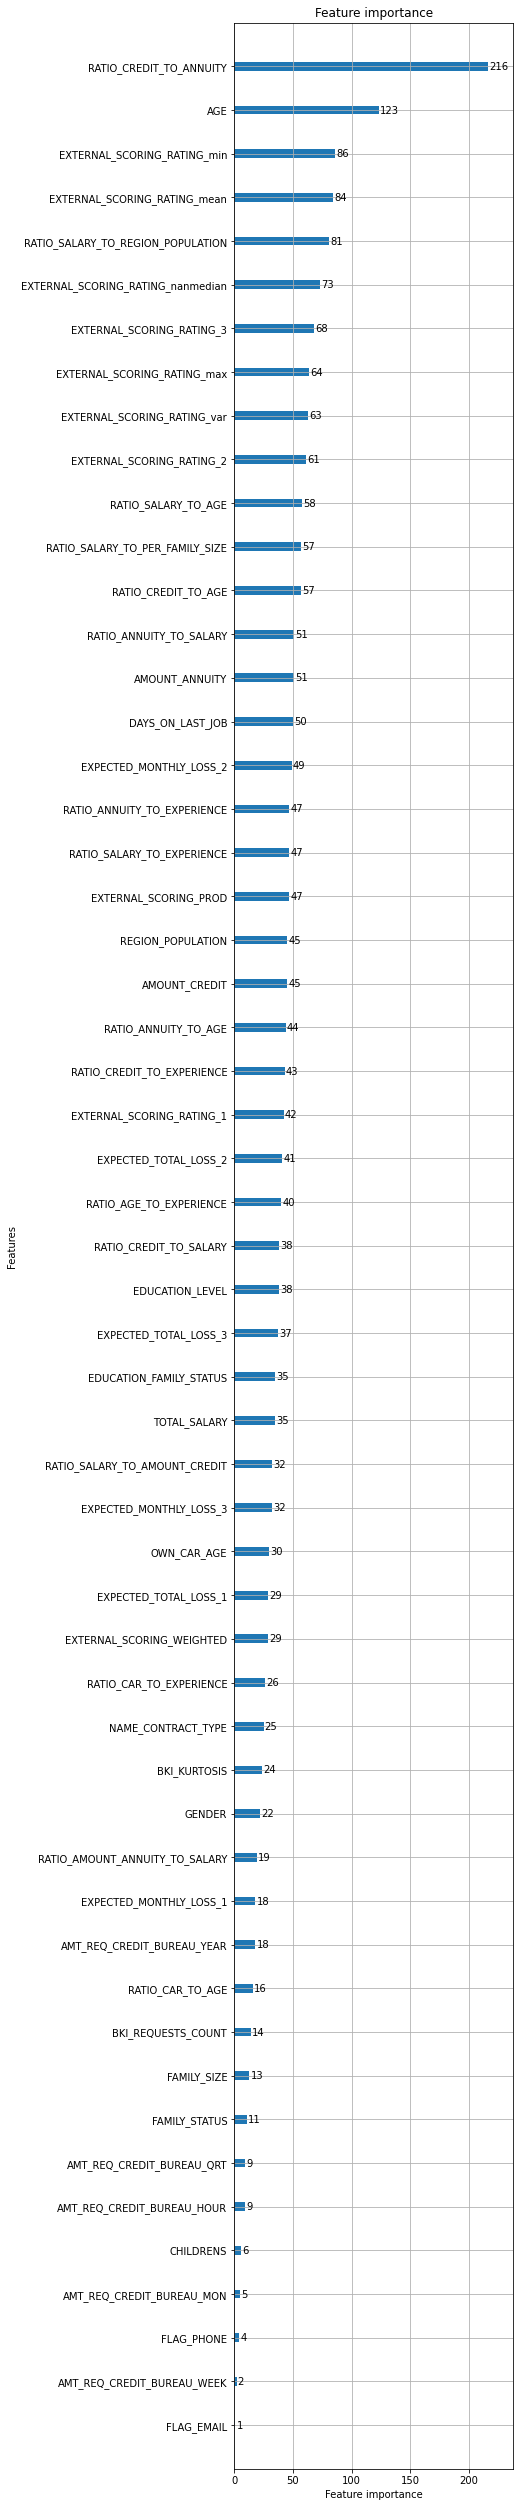

In [97]:
ax = lgbm.plot_importance(model, max_num_features=355, figsize=(5,45))   #, figsize=(45,5)
plt.show()

In [98]:
# keys = X_train.columns
# values = model.feature_importance()

# fi_dt = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
# fi_dt

In [99]:
feature_imp = pd.DataFrame({'Value':model.feature_importance(),'Feature':X_train.columns})

In [100]:
f_imp = feature_imp.sort_values("Value", ascending=False).reset_index(drop=True)

In [101]:
# pd.set_option('display.max_rows', 20)

In [102]:
f_imp.loc[f_imp['Value'] > 0, 'Feature']

0               RATIO_CREDIT_TO_ANNUITY
1                                   AGE
2           EXTERNAL_SCORING_RATING_min
3          EXTERNAL_SCORING_RATING_mean
4     RATIO_SALARY_TO_REGION_POPULATION
5     EXTERNAL_SCORING_RATING_nanmedian
6             EXTERNAL_SCORING_RATING_3
7           EXTERNAL_SCORING_RATING_max
8           EXTERNAL_SCORING_RATING_var
9             EXTERNAL_SCORING_RATING_2
10                  RATIO_SALARY_TO_AGE
11      RATIO_SALARY_TO_PER_FAMILY_SIZE
12                  RATIO_CREDIT_TO_AGE
13                       AMOUNT_ANNUITY
14              RATIO_ANNUITY_TO_SALARY
15                     DAYS_ON_LAST_JOB
16              EXPECTED_MONTHLY_LOSS_2
17           RATIO_SALARY_TO_EXPERIENCE
18                EXTERNAL_SCORING_PROD
19          RATIO_ANNUITY_TO_EXPERIENCE
20                    REGION_POPULATION
21                        AMOUNT_CREDIT
22                 RATIO_ANNUITY_TO_AGE
23           RATIO_CREDIT_TO_EXPERIENCE
24            EXTERNAL_SCORING_RATING_1


In [103]:
col_list = f_imp.loc[f_imp['Value'] > 0, 'Feature'].values

In [104]:
train_crop = train_prep[col_list]

In [105]:
train_cat_crop = train_cat_prep[col_list]

In [106]:
test_crop = test_prep[col_list]

In [107]:
test_cat_crop = test_cat_prep[col_list]

In [108]:
train_cat_crop.head(3)

,RATIO_CREDIT_TO_ANNUITY,AGE,EXTERNAL_SCORING_RATING_min,EXTERNAL_SCORING_RATING_mean,RATIO_SALARY_TO_REGION_POPULATION,EXTERNAL_SCORING_RATING_nanmedian,EXTERNAL_SCORING_RATING_3,EXTERNAL_SCORING_RATING_max,EXTERNAL_SCORING_RATING_var,EXTERNAL_SCORING_RATING_2,RATIO_SALARY_TO_AGE,RATIO_SALARY_TO_PER_FAMILY_SIZE,RATIO_CREDIT_TO_AGE,AMOUNT_ANNUITY,RATIO_ANNUITY_TO_SALARY,DAYS_ON_LAST_JOB,EXPECTED_MONTHLY_LOSS_2,RATIO_SALARY_TO_EXPERIENCE,EXTERNAL_SCORING_PROD,RATIO_ANNUITY_TO_EXPERIENCE,REGION_POPULATION,AMOUNT_CREDIT,RATIO_ANNUITY_TO_AGE,RATIO_CREDIT_TO_EXPERIENCE,EXTERNAL_SCORING_RATING_1,EXPECTED_TOTAL_LOSS_2,RATIO_AGE_TO_EXPERIENCE,RATIO_CREDIT_TO_SALARY,EDUCATION_LEVEL,EXPECTED_TOTAL_LOSS_3,EDUCATION_FAMILY_STATUS,TOTAL_SALARY,RATIO_SALARY_TO_AMOUNT_CREDIT,EXPECTED_MONTHLY_LOSS_3,OWN_CAR_AGE,EXTERNAL_SCORING_WEIGHTED,EXPECTED_TOTAL_LOSS_1,RATIO_CAR_TO_EXPERIENCE,NAME_CONTRACT_TYPE,BKI_KURTOSIS,GENDER,RATIO_AMOUNT_ANNUITY_TO_SALARY,EXPECTED_MONTHLY_LOSS_1,AMT_REQ_CREDIT_BUREAU_YEAR,RATIO_CAR_TO_AGE,BKI_REQUESTS_COUNT,FAMILY_SIZE,FAMILY_STATUS,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_QRT,CHILDRENS,AMT_REQ_CREDIT_BUREAU_MON,FLAG_PHONE,AMT_REQ_CREDIT_BUREAU_WEEK,FLAG_EMAIL
0,34.025788,15728.0,0.645914,0.687756,3008.4075,0.700784,0.716570,0.716570,0.000917,0.645914,10.013988,52500.0,54.361648,25128.0,0.159543,1719.0,16230.521013,91.623037,0.324353,14.617801,0.019101,855000.0,1.59766,497.382199,0.700784,552256.266546,9.149506,5.428571,Secondary / secondary special,612667.559305,Secondary / secondary special | Married,157500.0,0.184211,18005.977111,11.0,4.197193,599170.547652,0.006399,Cash,1.428571,M,0.159543,17609.307043,2.0,0.000699,3.0,3.0,Married,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,-1.000000,-1.0,-1.000000,-1.000000,-1.0000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.0,-1.000000,-1.0,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,No,-1.000000,No | No,-1.0,1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,Cash,-1.000000,No,1.000000,-1.000000,-1.0,-1.000000,-1.0,-1.0,No,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,23.603376,21557.0,0.267869,0.475009,3562.9200,0.475009,0.267869,0.682149,0.042907,0.682149,6.262467,67500.0,46.709653,42660.0,0.316000,3618.0,29100.493510,37.313433,-1.000000,11.791045,0.026392,1006920.0,1.97894,278.308458,-1.000000,686869.876357,5.958264,7.458667,Higher education,269722.588880,Higher education | Married,135000.0,0.134072,11427.288803,-1.0,-1.000000,-1.000000,-1.000000,Cash,0.539379,F,0.316000,-1.000000,4.0,-1.000000,11.0,2.0,Married,0.0,0.0,0.0,7.0,1.0,0.0,0.0


In [109]:
train_crop.to_csv(data_dir + "train_crop.csv", sep=";", index=False)

In [110]:
train_cat_crop.to_csv(data_dir + "train_cat_crop.csv", sep=";", index=False)

In [111]:
test_crop.to_csv(data_dir + "test_crop.csv", sep=";", index=False)

In [112]:
test_cat_crop.to_csv(data_dir + "test_cat_crop.csv", sep=";", index=False)

### Пермутированная важность (permutation importance)

In [113]:
def calculate_permutation_importance(estimator, 
                                     metric: callable,
                                     x_valid: pd.DataFrame,
                                     y_valid: pd.Series) -> pd.Series:
    """
    Расчет пермутированной важности признаков.
    """
    scores = {}
    y_pred = estimator.predict(x_valid)
    base_score = metric(y_valid, y_pred)

    for feature in tqdm(x_valid.columns):
        x_valid_copy = x_valid.copy()
        x_valid_copy[feature] = np.random.permutation(x_valid_copy[feature])

        y_pred = estimator.predict(x_valid_copy)
        score = metric(y_valid, y_pred)
        scores[feature] = base_score - score

    scores = pd.Series(scores)
    scores = scores.sort_values(ascending=False)

    return scores

In [114]:
X_train, X_valid, y_train, y_valid = train_test_split(train_prep.drop(["APPLICATION_NUMBER", "TARGET"], axis=1), 
                                                      train_prep["TARGET"], 
                                                      test_size=0.2, 
                                                      random_state=42)

train_data = lgbm.Dataset(X_train, label=y_train)
test_data = lgbm.Dataset(X_valid, label=y_valid)

model = lgbm.train(lgbm_params,
                   train_data,
                   valid_sets=test_data,
                   num_boost_round=1000,
                   early_stopping_rounds=50,
                   verbose_eval=False)

In [115]:
perm_importance = calculate_permutation_importance(
    estimator=model, metric=roc_auc_score, x_valid=X_valid, y_valid=y_valid
)

100%|██████████| 57/57 [00:04<00:00, 11.49it/s]


In [116]:
perm_importance

EXTERNAL_SCORING_RATING_mean          0.072075
RATIO_CREDIT_TO_ANNUITY               0.022737
RATIO_ANNUITY_TO_EXPERIENCE           0.022128
EXTERNAL_SCORING_RATING_3             0.008191
EDUCATION_LEVEL                       0.007480
AGE                                   0.006794
NAME_CONTRACT_TYPE                    0.006773
EXPECTED_MONTHLY_LOSS_3               0.005854
EXTERNAL_SCORING_RATING_min           0.005507
GENDER                                0.004383
AMOUNT_CREDIT                         0.004131
RATIO_CREDIT_TO_AGE                   0.004026
EXTERNAL_SCORING_RATING_nanmedian     0.003508
EXTERNAL_SCORING_RATING_2             0.003297
EXTERNAL_SCORING_RATING_max           0.002653
EXPECTED_MONTHLY_LOSS_2               0.002557
RATIO_SALARY_TO_AGE                   0.002144
RATIO_CREDIT_TO_EXPERIENCE            0.002120
EXTERNAL_SCORING_WEIGHTED             0.001990
EXTERNAL_SCORING_RATING_var           0.001586
RATIO_ANNUITY_TO_SALARY               0.001546
EXTERNAL_SCOR

In [117]:
col_list_2 = perm_importance[perm_importance > 0.0001].index

In [118]:
col_list_2

Index(['EXTERNAL_SCORING_RATING_mean', 'RATIO_CREDIT_TO_ANNUITY',
       'RATIO_ANNUITY_TO_EXPERIENCE', 'EXTERNAL_SCORING_RATING_3',
       'EDUCATION_LEVEL', 'AGE', 'NAME_CONTRACT_TYPE',
       'EXPECTED_MONTHLY_LOSS_3', 'EXTERNAL_SCORING_RATING_min', 'GENDER',
       'AMOUNT_CREDIT', 'RATIO_CREDIT_TO_AGE',
       'EXTERNAL_SCORING_RATING_nanmedian', 'EXTERNAL_SCORING_RATING_2',
       'EXTERNAL_SCORING_RATING_max', 'EXPECTED_MONTHLY_LOSS_2',
       'RATIO_SALARY_TO_AGE', 'RATIO_CREDIT_TO_EXPERIENCE',
       'EXTERNAL_SCORING_WEIGHTED', 'EXTERNAL_SCORING_RATING_var',
       'RATIO_ANNUITY_TO_SALARY', 'EXTERNAL_SCORING_RATING_1', 'TOTAL_SALARY',
       'EXPECTED_TOTAL_LOSS_2', 'EXPECTED_TOTAL_LOSS_3',
       'RATIO_AMOUNT_ANNUITY_TO_SALARY', 'RATIO_SALARY_TO_PER_FAMILY_SIZE',
       'EDUCATION_FAMILY_STATUS', 'REGION_POPULATION',
       'AMT_REQ_CREDIT_BUREAU_HOUR', 'EXTERNAL_SCORING_PROD',
       'EXPECTED_MONTHLY_LOSS_1', 'RATIO_ANNUITY_TO_AGE', 'FAMILY_STATUS',
       'EXPECTED_TOTA

In [119]:
train_crop_2 = train_prep[col_list_2]

In [120]:
train_cat_crop_2 = train_cat_prep[col_list_2]

In [121]:
test_crop_2 = test_prep[col_list_2]

In [122]:
test_cat_crop_2 = test_cat_prep[col_list_2]

In [123]:
test_cat_crop_2.head(3)

,EXTERNAL_SCORING_RATING_mean,RATIO_CREDIT_TO_ANNUITY,RATIO_ANNUITY_TO_EXPERIENCE,EXTERNAL_SCORING_RATING_3,EDUCATION_LEVEL,AGE,NAME_CONTRACT_TYPE,EXPECTED_MONTHLY_LOSS_3,EXTERNAL_SCORING_RATING_min,GENDER,AMOUNT_CREDIT,RATIO_CREDIT_TO_AGE,EXTERNAL_SCORING_RATING_nanmedian,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_max,EXPECTED_MONTHLY_LOSS_2,RATIO_SALARY_TO_AGE,RATIO_CREDIT_TO_EXPERIENCE,EXTERNAL_SCORING_WEIGHTED,EXTERNAL_SCORING_RATING_var,RATIO_ANNUITY_TO_SALARY,EXTERNAL_SCORING_RATING_1,TOTAL_SALARY,EXPECTED_TOTAL_LOSS_2,EXPECTED_TOTAL_LOSS_3,RATIO_AMOUNT_ANNUITY_TO_SALARY,RATIO_SALARY_TO_PER_FAMILY_SIZE,EDUCATION_FAMILY_STATUS,REGION_POPULATION,AMT_REQ_CREDIT_BUREAU_HOUR,EXTERNAL_SCORING_PROD,EXPECTED_MONTHLY_LOSS_1,RATIO_ANNUITY_TO_AGE,FAMILY_STATUS,EXPECTED_TOTAL_LOSS_1,RATIO_CREDIT_TO_SALARY,AMOUNT_ANNUITY,RATIO_SALARY_TO_EXPERIENCE,OWN_CAR_AGE,FLAG_PHONE,DAYS_ON_LAST_JOB,CHILDRENS
0,0.628266,34.199726,12.431973,-1.000000,Secondary / secondary special,16007.0,Cash,-1.000000,0.628266,M,1125000.0,70.281752,0.628266,0.628266,0.628266,20666.815272,7.309302,425.170068,-1.0,0.000000,0.281154,-1.0,117000.0,706799.427892,-1.000000,0.281154,58500.0,Secondary / secondary special | Married,0.028663,0.0,-1.0,-1.0,2.055038,Married,-1.0,9.615385,32895.0,44.217687,20.0,0.0,2646.0,0.0
1,0.383325,18.295341,37.245098,0.188490,Secondary / secondary special,10315.0,Cash,3222.322825,0.188490,F,312768.0,30.321667,0.383325,0.578161,0.578161,9883.951718,7.852642,681.411765,-1.0,0.037961,0.211056,-1.0,81000.0,180830.265914,58953.494506,0.211056,20250.0,Secondary / secondary special | Married,0.019689,0.0,-1.0,-1.0,1.657344,Married,-1.0,3.861333,17095.5,176.470588,-1.0,0.0,459.0,2.0
2,0.267523,20.000000,23.029683,0.382502,Secondary / secondary special,13016.0,Credit Card,8606.290593,0.152544,F,450000.0,34.572833,0.267523,0.152544,0.382502,3432.249216,12.100492,460.593654,-1.0,0.013220,0.142857,-1.0,157500.0,68644.984320,172125.811865,0.142857,39375.0,Secondary / secondary special | Married,0.019101,0.0,-1.0,-1.0,1.728642,Married,-1.0,2.857143,22500.0,161.207779,-1.0,1.0,977.0,2.0


In [124]:
train_crop_2.to_csv(data_dir + "train_crop_2.csv", sep=";", index=False)

In [125]:
train_cat_crop_2.to_csv(data_dir + "train_cat_crop_2.csv", sep=";", index=False)

In [126]:
test_crop_2.to_csv(data_dir + "test_crop_2.csv", sep=";", index=False)

In [127]:
test_cat_crop_2.to_csv(data_dir + "test_cat_crop_2.csv", sep=";", index=False)

### Подбор параметров на сокращённых наборах

In [128]:
def get_model_lgbm_reg_hp(parameters, X, y):
    clf = GridSearchCV(
        estimator=lgbm.LGBMClassifier(subsample=0.5, random_state=42),
        param_grid=parameters,
        scoring='roc_auc',
        cv=5,
        return_train_score = True
    )
    
    clf.fit(X, y)
    
    cv_results = pd.DataFrame(clf.cv_results_)

    #print(cv_results.columns)
    
    param_columns = [
        column
        for column in cv_results.columns
        if column.startswith('param_')
    ]

    score_columns = ['mean_test_score', 'mean_train_score']

    cv_results = (cv_results[param_columns + score_columns]
                  .sort_values(by=score_columns, ascending=False))

    print(cv_results)
    print(f"\nbest params: {clf.best_params_}\n")
    return clf

In [129]:
parameters_l_2 = {
    'num_leaves': [26, 31],
    # 'max_depth': [5], #, 3, 7
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.1, 0.05]
}

In [130]:
# clf_l_c1 = get_model_lgbm_reg_hp(parameters_l_2, train_crop,  train_prep["TARGET"])

In [131]:
# clf_l_c2 = get_model_lgbm_reg_hp(parameters_l_2, train_crop_2,  train_prep["TARGET"])

In [132]:
# best params: {'learning_rate': 0.05, 'n_estimators': 100, 'num_leaves': 26}
params_l_2_1 = {}
params_l_2_1["num_leaves"] = 26 # clf_l_c1.best_params_['num_leaves']
# params_l2["max_depth"] = clf_l_c1.best_params_['max_depth']
params_l_2_1["n_estimators"] = 100 # clf_l_c1.best_params_['n_estimators']
params_l_2_1["learning_rate"] = 0.05 # clf_l_c1.best_params_['learning_rate']

In [133]:
cv_strategy = KFold(n_splits=5, random_state=42)

estimators_lgbm_c1, oof_score_lgbm_c1, fold_train_scores_lgbm_c1, fold_valid_scores_lgbm_c1, oof_predictions_lgbm_c1 = make_cross_validation_adapt_l(
    train_crop,
    train_prep["TARGET"],
    params=params_l_2_1,
    metric=roc_auc_score, 
    cv_strategy=cv_strategy
)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Fold: 1, train-observations = 88074, valid-observations = 22019
train-score = 0.7568, valid-score = 0.7181
Fold: 2, train-observations = 88074, valid-observations = 22019
train-score = 0.7592, valid-score = 0.7196
Fold: 3, train-observations = 88074, valid-observations = 22019
train-score = 0.7536, valid-score = 0.7276
Fold: 4, train-observations = 88075, valid-observations = 22018
train-score = 0.7562, valid-score = 0.7217
Fold: 5, train-observations = 88075, valid-observations = 22018
train-score = 0.7526, valid-score = 0.7259
CV-results train: 0.7557 +/- 0.002
CV-results valid: 0.7226 +/- 0.004
OOF-score = 0.7219


In [134]:
# best params: {'learning_rate': 0.05, 'n_estimators': 200, 'num_leaves': 26}
params_l_2_2 = {}
params_l_2_2["num_leaves"] = 26 # clf_l_c2.best_params_['num_leaves']
# params_l2["max_depth"] = clf_l_c1.best_params_['max_depth']
params_l_2_2["n_estimators"] = 200 # clf_l_c2.best_params_['n_estimators']
params_l_2_2["learning_rate"] = 0.05 # clf_l_c2.best_params_['learning_rate']

In [135]:
cv_strategy = KFold(n_splits=5, random_state=42)

estimators_lgbm_c2, oof_score_lgbm_c2, fold_train_scores_lgbm_c2, fold_valid_scores_lgbm_c2, oof_predictions_lgbm_c2 = make_cross_validation_adapt_l(
    train_crop_2,
    train_prep["TARGET"],
    params=params_l_2_2,
    metric=roc_auc_score, 
    cv_strategy=cv_strategy
)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Fold: 1, train-observations = 88074, valid-observations = 22019
train-score = 0.7639, valid-score = 0.7201
Fold: 2, train-observations = 88074, valid-observations = 22019
train-score = 0.7849, valid-score = 0.7215
Fold: 3, train-observations = 88074, valid-observations = 22019
train-score = 0.7677, valid-score = 0.7321
Fold: 4, train-observations = 88075, valid-observations = 22018
train-score = 0.759, valid-score = 0.7221
Fold: 5, train-observations = 88075, valid-observations = 22018
train-score = 0.7547, valid-score = 0.7268
CV-results train: 0.766 +/- 0.01
CV-results valid: 0.7245 +/- 0.004
OOF-score = 0.7238


In [136]:
# best params: {'learning_rate': 0.05, 'n_estimators': 100, 'num_leaves': 26}
lgbm_params_2_1 =  {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    "num_leaves": 26, # clf_l_c1.best_params_['num_leaves'],
    "learning_rate": 0.05, # clf_l_c1.best_params_['learning_rate'],
    # "n_estimators": 100, # clf_l_c1.best_params_['n_estimators'],
    "random_state": 42 
    }

In [137]:
dftrainLGB = lgbm.Dataset(data = train_crop, 
                          label = train_prep["TARGET"])
                        #   feature_name = list(x_train))

cv_results_l_2_1 = lgbm.cv(
        lgbm_params_2_1,
        dftrainLGB,
        num_boost_round=2000,
        nfold=5,
        metrics='auc',
        early_stopping_rounds=50
        )

In [138]:
print(f"lgbm.cv auc-mean: {cv_results_l_2_1['auc-mean'][len(cv_results_l_2_1['auc-mean'])-1]:.4f}, \
auc-stdv: {cv_results_l_2_1['auc-stdv'][len(cv_results_l_2_1['auc-stdv'])-1]:.4f}")

lgbm.cv auc-mean: 0.7246, auc-stdv: 0.0063


In [139]:
# best params: {'learning_rate': 0.05, 'n_estimators': 200, 'num_leaves': 26}
lgbm_params_2_2 =  {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    "num_leaves": 26, # clf_l_c2.best_params_['num_leaves'],
    "learning_rate": 0.05, # clf_l_c2.best_params_['learning_rate'],
    # "n_estimators": 200, # clf_l_c2.best_params_['n_estimators'],
    "random_state": 42 
    }

In [140]:
dftrainLGB = lgbm.Dataset(data = train_crop_2, 
                          label = train_prep["TARGET"])
                        #   feature_name = list(x_train))

cv_results_l_2_2 = lgbm.cv(
        lgbm_params_2_2,
        dftrainLGB,
        num_boost_round=2000,
        nfold=5,
        metrics='auc',
        early_stopping_rounds=50
        )

In [141]:
print(f"lgbm.cv auc-mean: {cv_results_l_2_2['auc-mean'][len(cv_results_l_2_2['auc-mean'])-1]:.4f}, \
auc-stdv: {cv_results_l_2_2['auc-stdv'][len(cv_results_l_2_2['auc-stdv'])-1]:.4f}")

lgbm.cv auc-mean: 0.7241, auc-stdv: 0.0066


### LightGBM данные для загрузки

In [142]:
prediction_lgbm_c2 = test[['APPLICATION_NUMBER']].copy()
prediction_lgbm_c2["TARGET"] = 0
prediction_lgbm_c2.head()

,APPLICATION_NUMBER,TARGET
0,123724268,0
1,123456549,0
2,123428178,0
3,123619984,0
4,123671104,0


In [143]:
test_predictions_lgbm_f = np.zeros(prediction_lgbm_c2["TARGET"].shape[0])
test_predictions_lgbm_c1 = np.zeros(prediction_lgbm_c2["TARGET"].shape[0])
test_predictions_lgbm_c2 = np.zeros(prediction_lgbm_c2["TARGET"].shape[0])

for i in range(5):
    test_predictions_lgbm_f += estimators_lgbm_f[i].predict(test_prep.drop(["APPLICATION_NUMBER"], axis=1))
    test_predictions_lgbm_c1 += estimators_lgbm_c1[i].predict(test_crop)
    test_predictions_lgbm_c2 += estimators_lgbm_c2[i].predict(test_crop_2)

test_predictions_lgbm_f /= 5
test_predictions_lgbm_c1 /= 5
test_predictions_lgbm_c2 /= 5

In [144]:
prediction_lgbm_c2["TARGET"] = test_predictions_lgbm_c2.copy()
prediction_lgbm_c2.tail()

,APPLICATION_NUMBER,TARGET
165136,123487967,0.083382
165137,123536402,0.041342
165138,123718238,0.083382
165139,123631557,0.024214
165140,123433260,0.047503


In [145]:
prediction_lgbm_c2.to_csv(data_dir + "prediction_lgbm_c2.csv", sep=";", index=False)

## Валидация на XGBoost

In [146]:
def get_model_hp(parameters, X, y):
    clf = GridSearchCV(
        estimator=xgb.XGBClassifier(silent=False, subsample=0.5, random_state=42),
        param_grid=parameters,
        scoring='roc_auc',
        cv=5,
        return_train_score = True
    )
    
    clf.fit(X, y)
    
    cv_results = pd.DataFrame(clf.cv_results_)

    #print(cv_results.columns)
    
    param_columns = [
        column
        for column in cv_results.columns
        if column.startswith('param_')
    ]

    score_columns = ['mean_test_score', 'mean_train_score']

    cv_results = (cv_results[param_columns + score_columns]
                  .sort_values(by=score_columns, ascending=False))

    print(cv_results)
    print(f"\nbest params: {clf.best_params_}\n")
    return clf

In [147]:
parameters = {
    'max_depth': [4, 6, 8],
    'eta': [0.3, 0.05]
    }

In [ ]:
clf_1 = get_model_hp(parameters, train_crop,  train_prep["TARGET"])

  param_eta param_max_depth  mean_test_score  mean_train_score
0       0.3               4         0.719424          0.772341
3      0.05               4         0.719424          0.772341
1       0.3               6         0.712290          0.855976
4      0.05               6         0.712290          0.855976
2       0.3               8         0.705821          0.939217
5      0.05               8         0.705821          0.939217

best params: {'eta': 0.3, 'max_depth': 4}



In [ ]:
clf_2 = get_model_hp(parameters, train_crop_2,  train_prep["TARGET"])

  param_eta param_max_depth  mean_test_score  mean_train_score
0       0.3               4         0.722111          0.766573
3      0.05               4         0.722111          0.766573
1       0.3               6         0.716208          0.842956
4      0.05               6         0.716208          0.842956
2       0.3               8         0.709395          0.928404
5      0.05               8         0.709395          0.928404

best params: {'eta': 0.3, 'max_depth': 4}



In [148]:
def make_cross_validation_adapt(X: pd.DataFrame,
                                y: pd.Series,
                                params: Dict,
                                metric: callable,
                                cv_strategy):
    """
    Кросс-валидация.

    Parameters
    ----------
    X: pd.DataFrame
        Матрица признаков.

    y: pd.Series
        Вектор целевой переменной.

    params: Dict
        Параметры модели.

    metric: callable
        Метрика для оценки качества решения.
        Ожидается, что на вход будет передана функция,
        которая принимает 2 аргумента: y_true, y_pred.

    cv_strategy: cross-validation generator
        Объект для описания стратегии кросс-валидации.
        Ожидается, что на вход будет передан объект типа
        KFold или StratifiedKFold.

    Returns
    -------
    oof_score: float
        Значение метрики качества на OOF-прогнозах.

    fold_train_scores: List[float]
        Значение метрики качества на каждом обучающем датасете кросс-валидации.

    fold_valid_scores: List[float]
        Значение метрики качества на каждом валидационном датасете кросс-валидации.

    oof_predictions: np.array
        Прогнозы на OOF.

    """
    estimators, fold_train_scores, fold_valid_scores = [], [], []
    oof_predictions = np.zeros(X.shape[0])

    plst = list(params.items())

    num_rounds=1000 
    
    for fold_number, (train_idx, valid_idx) in enumerate(cv_strategy.split(X, y)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y.loc[train_idx], y.loc[valid_idx]

        xgtrain = xgb.DMatrix(x_train, label=y_train)
        xgval = xgb.DMatrix(x_valid, label=y_valid)

        watchlist = [(xgtrain,'train'), (xgval,'eval')]

        model = xgb.train(plst, 
                          xgtrain, 
                          num_rounds,
                          watchlist,
                          verbose_eval=False,
                          early_stopping_rounds=10)

        y_train_pred = model.predict(xgtrain)
        y_valid_pred = model.predict(xgval)

        fold_train_scores.append(metric(y_train, y_train_pred))
        fold_valid_scores.append(metric(y_valid, y_valid_pred))
        oof_predictions[valid_idx] = y_valid_pred

        msg = (
            f"Fold: {fold_number+1}, train-observations = {len(train_idx)}, "
            f"valid-observations = {len(valid_idx)}\n"
            f"train-score = {round(fold_train_scores[fold_number], 4)}, "
            f"valid-score = {round(fold_valid_scores[fold_number], 4)}" 
        )
        print(msg)
        print("="*69)
        estimators.append(model)

    oof_score = metric(y, oof_predictions)
    print(f"CV-results train: {round(np.mean(fold_train_scores), 4)} +/- {round(np.std(fold_train_scores), 3)}")
    print(f"CV-results valid: {round(np.mean(fold_valid_scores), 4)} +/- {round(np.std(fold_valid_scores), 3)}")
    print(f"OOF-score = {round(oof_score, 4)}")

    return estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions

In [149]:
# best params: {'eta': 0.3, 'max_depth': 4}
params = {}
params["objective"] = "binary:logistic"
params["eta"] = 0.3 # clf_1.best_params_['eta']
# params["n_estimators"] = clf.best_params_['n_estimators']
params["random_state"] = 42
params["silent"] = 1
params["max_depth"] = 4 # clf_1.best_params_['max_depth']
params["eval_metric"] = "auc"

In [150]:
cv_strategy = KFold(n_splits=5, random_state=42)

estimators_xgb_c1, oof_score_xgb_c1, fold_train_scores_xgb_c1, fold_valid_scores_xgb_c1, oof_predictions_xgb_c1 = make_cross_validation_adapt(
    train_crop,
    train_prep["TARGET"],
    params=params,
    metric=roc_auc_score, 
    cv_strategy=cv_strategy
)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Fold: 1, train-observations = 88074, valid-observations = 22019
train-score = 0.7605, valid-score = 0.7214
Fold: 2, train-observations = 88074, valid-observations = 22019
train-score = 0.7603, valid-score = 0.7152
Fold: 3, train-observations = 88074, valid-observations = 22019
train-score = 0.7722, valid-score = 0.7261
Fold: 4, train-observations = 88075, valid-observations = 22018
train-score = 0.767, valid-score = 0.7237
Fold: 5, train-observations = 88075, valid-observations = 22018
train-score = 0.7644, valid-score = 0.7288
CV-results train: 0.7649 +/- 0.004
CV-results valid: 0.723 +/- 0.005
OOF-score = 0.7224


In [152]:
estimators_xgb_c2, oof_score_xgb_c2, fold_train_scores_xgb_c2, fold_valid_scores_xgb_c2, oof_predictions_xgb_c2 = make_cross_validation_adapt(
    train_crop_2,
    train_prep["TARGET"],
    params=params,
    metric=roc_auc_score, 
    cv_strategy=cv_strategy
)

Fold: 1, train-observations = 88074, valid-observations = 22019
train-score = 0.7686, valid-score = 0.7227
Fold: 2, train-observations = 88074, valid-observations = 22019
train-score = 0.7622, valid-score = 0.7158
Fold: 3, train-observations = 88074, valid-observations = 22019
train-score = 0.7653, valid-score = 0.7297
Fold: 4, train-observations = 88075, valid-observations = 22018
train-score = 0.7694, valid-score = 0.7253
Fold: 5, train-observations = 88075, valid-observations = 22018
train-score = 0.775, valid-score = 0.7315
CV-results train: 0.7681 +/- 0.004
CV-results valid: 0.725 +/- 0.006
OOF-score = 0.7243


In [153]:
cv_results_1 = xgb.cv(dtrain=xgb.DMatrix(train_crop, label=train_prep["TARGET"]), 
                      params=params, 
                      nfold=5,
                      num_boost_round=1000,
                      early_stopping_rounds=50,
                      metrics="auc", 
                      as_pandas=True, 
                      seed=42)

In [154]:
cv_results_2 = xgb.cv(dtrain=xgb.DMatrix(train_crop_2, label=train_prep["TARGET"]), 
                      params=params, 
                      nfold=5,
                      num_boost_round=1000,
                      early_stopping_rounds=50,
                      metrics="auc", 
                      as_pandas=True, 
                      seed=42)

In [155]:
cv_results_1.head()

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.697604,0.002723,0.690621,0.008935
1,0.705078,0.002355,0.697573,0.008101
2,0.707977,0.002137,0.699932,0.008812
3,0.709954,0.001699,0.702140,0.009763
4,0.712184,0.001634,0.703596,0.009685


In [156]:
cv_results_2.head()

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.697223,0.003287,0.690523,0.008127
1,0.705101,0.002386,0.697947,0.008335
2,0.708072,0.002049,0.700387,0.008483
3,0.710335,0.001473,0.702239,0.009304
4,0.712247,0.001914,0.704470,0.009814


In [157]:
print((cv_results_1["test-auc-mean"]).tail(1))

55    0.726136
Name: test-auc-mean, dtype: float64


In [158]:
print((cv_results_2["test-auc-mean"]).tail(1))

53    0.726141
Name: test-auc-mean, dtype: float64


### XGBoost данные для загрузки

In [159]:
prediction_xgb_c2 = test[['APPLICATION_NUMBER']].copy()
prediction_xgb_c2["TARGET"] = 0
prediction_xgb_c2.head()

,APPLICATION_NUMBER,TARGET
0,123724268,0
1,123456549,0
2,123428178,0
3,123619984,0
4,123671104,0


In [160]:
test_predictions_xgb_c1 = np.zeros(prediction_xgb_c2["TARGET"].shape[0])
test_predictions_xgb_c2 = np.zeros(prediction_xgb_c2["TARGET"].shape[0])

for i in range(5):
    test_predictions_xgb_c1 += estimators_xgb_c1[i].predict(xgb.DMatrix(test_crop))
    test_predictions_xgb_c2 += estimators_xgb_c2[i].predict(xgb.DMatrix(test_crop_2))

test_predictions_xgb_c1 /= 5
test_predictions_xgb_c2 /= 5

In [161]:
prediction_xgb_c2["TARGET"] = test_predictions_xgb_c2.copy()
prediction_xgb_c2.tail()

,APPLICATION_NUMBER,TARGET
165136,123487967,0.083777
165137,123536402,0.042287
165138,123718238,0.083777
165139,123631557,0.011741
165140,123433260,0.039882


In [162]:
prediction_xgb_c2.to_csv(data_dir + "prediction_xgb_c2.csv", sep=";", index=False)

## Валидация на CatBoost

In [163]:
import time

def catboost_cross_validation(params, X, y, cv, categorical = None):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признаков для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    estimators, folds_scores = [], []
    oof_preds = np.zeros(X.shape[0])

    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")
    X[categorical] = X[categorical].astype(str)

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):

        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        model = catb.CatBoostClassifier(**params)
        model.fit(
            x_train, y_train, categorical,
            eval_set=[(x_train, y_train), (x_valid, y_valid)],
            verbose_eval=False
        )
        oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        folds_scores.append(round(score, 5))
        estimators.append(model)

    print(f"Score by each fold: {folds_scores}")
    print("="*65)
    return estimators, oof_preds

In [164]:
cb_params = {
    "n_estimators": 2000,
    "learning_rate": 0.01,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 10,
    "max_depth": 6,
    "l2_leaf_reg": 10,
    "early_stopping_rounds": 50,
    "thread_count": 6,
    "random_seed": 42
}

cv = KFold(n_splits=5, random_state=42, shuffle=True)

In [165]:
train_cat = train_cat_prep.drop(["APPLICATION_NUMBER", "TARGET"], axis=1)
categorial = train_cat.dtypes[train_cat.dtypes == "object"].index
estimators_catb_f, oof_preds_catb_f = catboost_cross_validation(
        params=cb_params, 
        X=train_cat, 
        y=train_prep["TARGET"], 
        cv=cv, 
        categorical=categorial
)

Wed Sep 30 16:20:00 2020, Cross-Validation, 110093 rows, 57 cols
Fold 1, Valid score = 0.73996
Fold 2, Valid score = 0.70099
Fold 3, Valid score = 0.72511
Fold 4, Valid score = 0.72847
Fold 5, Valid score = 0.71309
Score by each fold: [0.73996, 0.70099, 0.72511, 0.72847, 0.71309]


In [166]:
score = roc_auc_score(train_prep["TARGET"].values, oof_preds_catb_f)
print(f"OOF-score = {score:.4f}")

OOF-score = 0.6817


In [167]:
categorial = train_cat_crop.dtypes[train_cat_crop.dtypes == "object"].index
estimators_catb_c1, oof_preds_catb_c1 = catboost_cross_validation(
        params=cb_params, 
        X=train_cat_crop, 
        y=train_prep["TARGET"], 
        cv=cv, 
        categorical=categorial
)

Wed Sep 30 16:31:20 2020, Cross-Validation, 110093 rows, 55 cols


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Fold 1, Valid score = 0.73803
Fold 2, Valid score = 0.71855
Fold 3, Valid score = 0.72585
Fold 4, Valid score = 0.72383
Fold 5, Valid score = 0.71124
Score by each fold: [0.73803, 0.71855, 0.72585, 0.72383, 0.71124]


In [168]:
score = roc_auc_score(train_prep["TARGET"].values, oof_preds_catb_c1)
print(f"OOF-score = {score:.4f}")

OOF-score = 0.7225


In [169]:
categorial = train_cat_crop_2.dtypes[train_cat_crop_2.dtypes == "object"].index
estimators_catb_c2, oof_preds_catb_c2 = catboost_cross_validation(
        params=cb_params, 
        X=train_cat_crop_2, 
        y=train_prep["TARGET"], 
        cv=cv, 
        categorical=categorial
)

Wed Sep 30 16:41:10 2020, Cross-Validation, 110093 rows, 42 cols


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Fold 1, Valid score = 0.73965
Fold 2, Valid score = 0.71944
Fold 3, Valid score = 0.72507
Fold 4, Valid score = 0.72901
Fold 5, Valid score = 0.71043
Score by each fold: [0.73965, 0.71944, 0.72507, 0.72901, 0.71043]


In [170]:
score = roc_auc_score(train_prep["TARGET"].values, oof_preds_catb_c2)
print(f"OOF-score = {score:.4f}")

OOF-score = 0.7238


### CatBoost данные для загрузки

In [173]:
prediction_cat_c2 = test[['APPLICATION_NUMBER']].copy()
prediction_cat_c2["TARGET"] = 0
prediction_cat_c2.head()

,APPLICATION_NUMBER,TARGET
0,123724268,0
1,123456549,0
2,123428178,0
3,123619984,0
4,123671104,0


In [174]:
test_preds_catb_f = np.zeros(prediction_cat_c1["TARGET"].shape[0])
test_preds_catb_c1 = np.zeros(prediction_cat_c1["TARGET"].shape[0])
test_preds_catb_c2 = np.zeros(prediction_cat_c2["TARGET"].shape[0])

for i in range(5):
    test_preds_catb_f += estimators_catb_f[i].predict_proba(test_prep.drop(["APPLICATION_NUMBER"], axis=1))[:, 1]
    test_preds_catb_c1 += estimators_catb_c1[i].predict_proba(test_cat_crop)[:, 1]
    test_preds_catb_c2 += estimators_catb_c2[i].predict_proba(test_cat_crop_2)[:, 1]

test_preds_catb_f /= 5
test_preds_catb_c1 /= 5
test_preds_catb_c2 /= 5

In [175]:
prediction_cat_c2["TARGET"] = test_preds_catb_c2.copy()
prediction_cat_c2.tail()

,APPLICATION_NUMBER,TARGET
165136,123487967,0.084415
165137,123536402,0.045372
165138,123718238,0.084415
165139,123631557,0.020927
165140,123433260,0.049755


In [176]:
prediction_cat_c2.to_csv(data_dir + "prediction_cat_c2.csv", sep=";", index=False)

## Ансамбли

In [179]:
np.corrcoef([oof_predictions_lgbm_c2, oof_predictions_xgb_c2, oof_preds_catb_c2])

array([[1.        , 0.94399823, 0.95246355],
       [0.94399823, 1.        , 0.93992256],
       [0.95246355, 0.93992256, 1.        ]])

In [180]:
all_model_pred = pd.DataFrame({
    "xgb_crop2": oof_predictions_xgb_c2,
    "lgbm_crop2": oof_predictions_lgbm_c2,
    "catb_crop2": oof_preds_catb_c2,
    # "catb_full": oof_preds_catb_f,
    "catb_crop1": oof_preds_catb_c1,
    "lgbm_full": oof_predictions_lgbm_f,
    "lgbm_crop1": oof_predictions_lgbm_c1,
    "xgb_crop1": oof_predictions_xgb_c1,
    # "mean": mean_predictions,
    # "geom": geom_predictions
})

In [181]:
all_model_pred.corr()

,xgb_crop2,lgbm_crop2,catb_crop2,catb_crop1,lgbm_full,lgbm_crop1,xgb_crop1
xgb_crop2,1.000000,0.943998,0.939923,0.937478,0.932255,0.943495,0.957229
lgbm_crop2,0.943998,1.000000,0.952464,0.950199,0.970131,0.981676,0.943014
catb_crop2,0.939923,0.952464,1.000000,0.995918,0.942615,0.957786,0.941518
catb_crop1,0.937478,0.950199,0.995918,1.000000,0.941607,0.957284,0.940191
lgbm_full,0.932255,0.970131,0.942615,0.941607,1.000000,0.974274,0.933485
lgbm_crop1,0.943495,0.981676,0.957786,0.957284,0.974274,1.000000,0.945392
xgb_crop1,0.957229,0.943014,0.941518,0.940191,0.933485,0.945392,1.000000


In [187]:
for name in all_model_pred.columns[1:]:
    mean_01 = (all_model_pred[all_model_pred.columns[0]] + all_model_pred[name]) / 2
    geom_01 = abs(all_model_pred[all_model_pred.columns[0]] * all_model_pred[name]) ** 0.5
    score_m = roc_auc_score(train_prep["TARGET"].values, mean_01)
    score_g = roc_auc_score(train_prep["TARGET"].values, geom_01)
    print(f"{all_model_pred.columns[0]} & {name} mean {score_m:.4f} geom {score_g:.4f}")

xgb_crop2 & lgbm_crop2 mean 0.7262 geom 0.7264
xgb_crop2 & catb_crop2 mean 0.7264 geom 0.7262
xgb_crop2 & catb_crop1 mean 0.7258 geom 0.7257
xgb_crop2 & lgbm_full mean 0.7257 geom 0.7258
xgb_crop2 & lgbm_crop1 mean 0.7255 geom 0.7255
xgb_crop2 & xgb_crop1 mean 0.7251 geom 0.7253


In [188]:
mean_predictions = all_model_pred.sum(axis=1)/len(all_model_pred.columns)
# mean_predictions

In [189]:
score = roc_auc_score(train_prep["TARGET"].values, mean_predictions)
print(f"OOF-score = {score:.4f}")

OOF-score = 0.7260


In [191]:
geom_predictions = abs(all_model_pred.product(axis=1)) ** (1/len(all_model_pred.columns))
# geom_predictions

In [192]:
score = roc_auc_score(train_prep["TARGET"].values, geom_predictions)
print(f"OOF-score = {score:.4f}")

OOF-score = 0.7260


In [193]:
all_model_pred['mean'] = mean_predictions
all_model_pred['geom'] = geom_predictions
all_model_pred.head()

,xgb_crop2,lgbm_crop2,catb_crop2,catb_crop1,lgbm_full,lgbm_crop1,xgb_crop1,mean,geom
0,0.014117,0.019249,0.024340,0.024379,0.021370,0.021787,0.014065,0.019901,0.019457
1,0.082460,0.082139,0.085041,0.084866,0.081546,0.081650,0.083004,0.082958,0.082947
2,0.051301,0.046670,0.058943,0.055423,0.046691,0.055893,0.051470,0.052342,0.052161
3,0.164403,0.177305,0.220724,0.199857,0.180841,0.177747,0.198126,0.188429,0.187638
4,0.082460,0.082139,0.083480,0.083360,0.081546,0.081650,0.083004,0.082520,0.082517


In [194]:
mean3 = (oof_predictions_xgb_c2 + oof_predictions_lgbm_c2 + oof_preds_catb_c2) / 3
score = roc_auc_score(train_prep["TARGET"].values, mean3)
print(f"OOF-score = {score:.4f}")

OOF-score = 0.7267


In [196]:
geom3 = abs(oof_predictions_xgb_c2 + oof_predictions_lgbm_c2 + oof_preds_catb_c2) ** (1/3)
score = roc_auc_score(train_prep["TARGET"].values, geom3)
print(f"OOF-score = {score:.4f}")

OOF-score = 0.7267


In [200]:
all_model_pred['mean3'] = mean3
all_model_pred['geom3'] = geom3
all_model_pred.head()

,xgb_crop2,lgbm_crop2,catb_crop2,catb_crop1,lgbm_full,lgbm_crop1,xgb_crop1,mean,geom,mean3,geom3
0,0.014117,0.019249,0.024340,0.024379,0.021370,0.021787,0.014065,0.019901,0.019457,0.019235,0.386430
1,0.082460,0.082139,0.085041,0.084866,0.081546,0.081650,0.083004,0.082958,0.082947,0.083213,0.629658
2,0.051301,0.046670,0.058943,0.055423,0.046691,0.055893,0.051470,0.052342,0.052161,0.052305,0.539371
3,0.164403,0.177305,0.220724,0.199857,0.180841,0.177747,0.198126,0.188429,0.187638,0.187477,0.825449
4,0.082460,0.082139,0.083480,0.083360,0.081546,0.081650,0.083004,0.082520,0.082517,0.082693,0.628343


### Отбор моделей

In [201]:
X_train, X_valid, y_train, y_valid = train_test_split(all_model_pred, 
                                                      train_prep["TARGET"], 
                                                      test_size=0.2, 
                                                      random_state=42)

train_data = lgbm.Dataset(X_train, label=y_train)
test_data = lgbm.Dataset(X_valid, label=y_valid)

model = lgbm.train(lgbm_params,
                   train_data,
                   valid_sets=test_data,
                   num_boost_round=1000,
                   early_stopping_rounds=50,
                   verbose_eval=False)

In [202]:
perm_importance = calculate_permutation_importance(
    estimator=model, metric=roc_auc_score, x_valid=X_valid, y_valid=y_valid
)

100%|██████████| 11/11 [00:00<00:00, 58.19it/s]


In [203]:
perm_importance

geom3         0.066243
mean          0.054165
catb_crop1    0.018880
mean3         0.010946
lgbm_crop1    0.007326
xgb_crop2     0.005325
geom          0.004093
lgbm_full     0.001550
catb_crop2    0.000665
xgb_crop1     0.000584
lgbm_crop2    0.000541
dtype: float64

In [204]:
model_list = perm_importance[perm_importance > 0.0001].index

In [205]:
model_list_crop = all_model_pred[model_list]

In [206]:
lgbm_params =  {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    "num_leaves": 26,
    "learning_rate": 0.05,
    # "n_estimators": 100, # clf_l_c1.best_params_['n_estimators'],
    "random_state": 42 
    }

In [207]:
dftrainLGB = lgbm.Dataset(data = model_list_crop, 
                          label = train_prep["TARGET"])
                        #   feature_name = list(x_train))

cv_results = lgbm.cv(
        lgbm_params,
        dftrainLGB,
        num_boost_round=2000,
        nfold=5,
        metrics='auc',
        early_stopping_rounds=50
        )

In [208]:
print(f"lgbm.cv auc-mean: {cv_results['auc-mean'][len(cv_results['auc-mean'])-1]:.4f}, \
auc-stdv: {cv_results['auc-stdv'][len(cv_results['auc-stdv'])-1]:.4f}")

lgbm.cv auc-mean: 0.7268, auc-stdv: 0.0067


### Ансамбли - данные для загрузки

#### Усреднение

In [216]:
prediction_mean = test_prep[['APPLICATION_NUMBER']].copy()
prediction_mean["TARGET"] = (test_predictions_xgb_c2 + test_predictions_lgbm_c2 + test_preds_catb_c2) / 3
prediction_mean.head()

,APPLICATION_NUMBER,TARGET
0,123724268,0.064819
1,123456549,0.213922
2,123428178,0.158536
3,123619984,0.083858
4,123671104,0.024418


In [217]:
prediction_mean.to_csv(data_dir + "prediction_mean3.csv", sep=";", index=False)

In [218]:
prediction_geom = test_prep[['APPLICATION_NUMBER']].copy()
prediction_geom["TARGET"] = abs(test_predictions_xgb_c2 * test_predictions_lgbm_c2 * test_preds_catb_c2) ** (1/3)
prediction_geom.head()

,APPLICATION_NUMBER,TARGET
0,123724268,0.064667
1,123456549,0.213776
2,123428178,0.156616
3,123619984,0.083857
4,123671104,0.024349


In [219]:
prediction_geom.to_csv(data_dir + "geom3.csv", sep=";", index=False)

#### Стекинг

In [221]:
all_model_test_pred = pd.DataFrame({
    "xgb_crop2": test_predictions_xgb_c2,
    "lgbm_crop2": test_predictions_lgbm_c2,
    "catb_crop2": test_preds_catb_c2,
    # "catb_full": test_preds_catb_f,
    "catb_crop1": test_preds_catb_c1,
    "lgbm_full": test_predictions_lgbm_f,
    "lgbm_crop1": test_predictions_lgbm_c1,
    "xgb_crop1": test_predictions_xgb_c1,
    # "mean": mean_predictions,
    # "geom": geom_predictions
})

In [223]:
all_model_test_pred['mean'] = all_model_test_pred.sum(axis=1) / len(all_model_test_pred.columns)
all_model_test_pred['geom'] = abs(all_model_test_pred.product(axis=1)) ** (1/len(all_model_test_pred.columns))
all_model_test_pred['mean3'] = (test_predictions_xgb_c2 + test_predictions_lgbm_c2 + test_preds_catb_c2) / 3
all_model_test_pred['geom3'] = abs(test_predictions_xgb_c2 * test_predictions_lgbm_c2 * test_preds_catb_c2) ** (1/3)
all_model_test_pred.head()

,xgb_crop2,lgbm_crop2,catb_crop2,catb_crop1,lgbm_full,lgbm_crop1,xgb_crop1,mean,geom,mean3,geom3
0,0.071153,0.061153,0.062150,0.059543,0.059181,0.058532,0.074109,0.063664,0.063464,0.064819,0.064667
1,0.220467,0.202892,0.218408,0.209932,0.208532,0.206319,0.218456,0.212134,0.212058,0.213922,0.213776
2,0.129555,0.156116,0.189937,0.198335,0.153077,0.151738,0.145250,0.160421,0.159191,0.158536,0.156616
3,0.083777,0.083382,0.084415,0.084353,0.083153,0.083015,0.083989,0.083726,0.083725,0.083858,0.083857
4,0.022115,0.024577,0.026562,0.025596,0.021710,0.024303,0.028943,0.024819,0.024734,0.024418,0.024349


In [226]:
X_train, X_valid, y_train, y_valid = train_test_split(model_list_crop, 
                                                      train_prep["TARGET"], 
                                                      test_size=0.2, 
                                                      random_state=42)

# dftrainLGB = lgbm.Dataset(data = model_list_crop, label = train_prep["TARGET"])

model = lgbm.LGBMRegressor(num_leaves=26,
                           n_estimators=100,
                           learning_rate=0.05,
                           subsample=0.5, 
                           seed=42)

model.fit(X_train, y_train,
          early_stopping_rounds=50, 
          eval_set = [(X_valid, y_valid)], 
          eval_metric = 'auc', 
          verbose=False)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.05, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=26, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, seed=42,
              silent=True, subsample=0.5, subsample_for_bin=200000,
              subsample_freq=0)

In [227]:
prediction_st = test_prep[['APPLICATION_NUMBER']].copy()
prediction_st["TARGET"] = model.predict(all_model_test_pred)
prediction_st.head()

,APPLICATION_NUMBER,TARGET
0,123724268,0.059287
1,123456549,0.124318
2,123428178,0.110666
3,123619984,0.082733
4,123671104,0.032844


In [228]:
prediction_st.tail()

,APPLICATION_NUMBER,TARGET
165136,123487967,0.082733
165137,123536402,0.049473
165138,123718238,0.082733
165139,123631557,0.027893
165140,123433260,0.050812


In [229]:
prediction_st.to_csv(data_dir + "prediction_st.csv", sep=";", index=False)